... maybe also add: RGI60-17.05181

In [1]:
#rgi_id = 'RGI60-11.00897'#, 'RGI60-15.11693' #'RGI60-11.01450'
rgi_ids = ['RGI60-11.01450',
           'RGI60-13.54431',  #largest glacier in RGI13
           'RGI60-16.01251', # largest glacier in RGI16 ADDED
           'RGI60-01.13696', # largest glacier in RGI01 ADDED 
           'RGI60-03.01710',  # largest glacier in RGi03
            # 
           #'RGI60-17.05181',
           'RGI60-04.06187'
           #'RGI60-15.11693',
           #'RGI60-11.00897',
           ]
# to check here: https://github.com/windnage/wgms-glacier-project/blob/main/notebooks/7-analyze-region-16-low-latitudes.ipynb
#f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
#json.load(f)['6243']
#Aletsch glacier is in the RHONE basin, where the driest months are in  June, July, August
# so we will select those months 
rgi_id = rgi_ids[0]

In [2]:
#!pip install --upgrade geopandas

In [3]:
load_dry_melt_months = False
if load_dry_melt_months:
    odf = pd.read_hdf(oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
    w5e5_path_pr = '/home/www/lschuster/w5e5v2.0/_script/pr_W5E5v2.0_*'
    ds_pr = xr.open_mfdataset(w5e5_path_pr)
    ds_pr = ds_pr.sel(time=slice('1989-11',str('2019-12'))) # want to have full consecutive months of three years
    # create monthly seasonal statistics
    ds_pr = ds_pr.resample(time='1M').mean()*60*60*24 # seconds to minutes to hours to days 
    ds_pr = ds_pr.pr.load()
    ds_pr_3m_sum = ds_pr.rolling(time=3, #center=True,
                                 min_periods=3).sum().dropna(dim='time')

    sel_rgi_ids = ['RGI60-11.01450',
               'RGI60-13.54431',  #largest glacier in RGI13
               'RGI60-16.01251', # largest glacier in RGI16 ADDED
               'RGI60-01.13696', # largest glacier in RGI01 ADDED 
               'RGI60-03.01710',  # largest glacier in RGi03
                # 
               'RGI60-04.06187',
               'RGI60-15.11693',
               'RGI60-11.00897',
                  'RGI60-17.05181']
    dry_last_month_glacier_d = {}
    for r in sel_rgi_ids:
        ##### this here is just to get the melt months .... 
        rreg = r[6:8]
        f_rgi_path =f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/RGI{rreg}/'
        ds = xr.open_mfdataset(f'{f_rgi_path}run_hydro_w5e5_gcm_merged_from_2000_gfdl-esm2m_stab_T15_endyr_2500_bc_1980_2019_rgi{rreg}_*.nc')[['melt_off_glacier_monthly','melt_on_glacier_monthly',
                                                                                                                                              'liq_prcp_off_glacier_monthly','liq_prcp_on_glacier_monthly']]
        ds = ds.sel(rgi_id = r).load()

        ds['runoff_monthly'] = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly']  + ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly']
        ds['melt_off_on_monthly'] = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly'] 
        ds_drymonths = ds[['runoff_monthly','melt_off_on_monthly']].copy()
        ds_drymonths.coords['year'] = ds_drymonths.coords['time'].astype(int)
        ds_drymonths.coords['month'] = ds_drymonths.month_2d
        ds_drymonths = ds_drymonths.stack(year_month = ("time","month_2d"))
        ds_drymonths['year_month'] = ds_drymonths.year + (ds_drymonths.month-1)/12
        ds_drymonths['melt_off_on_monthly'] = ds_drymonths['melt_off_on_monthly'].rolling(year_month=3, min_periods=3).mean()
        ds_drymonths['melt_off_on_monthly'] = ds_drymonths['melt_off_on_monthly'].dropna(dim='year_month')

        _sel = ds_drymonths.melt_off_on_monthly.sel(year_month=slice(2000 + 2/12,2020 + 1/12))#.sel(scenario=scenarios)

        _rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last = _sel.groupby('month').mean()

        # here we just use one 
        _rgi_median_past_seasonal_avg_melt_off_on_monthly_3mavg_last = _rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last.median(dim='month')
        # now, just take those months of every basin where melt is equal or above the median
        _rgi_sel_pd_months_w_melt_above_eq_median = _rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last.where(_rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last>=_rgi_median_past_seasonal_avg_melt_off_on_monthly_3mavg_last).to_dataframe().reset_index()
        _rgi_sel_pd_months_w_melt_above_eq_median = _rgi_sel_pd_months_w_melt_above_eq_median.dropna()
        assert len(_rgi_sel_pd_months_w_melt_above_eq_median) == 6
        _rgi_sel_pd_months_w_melt_above_eq_median = _rgi_sel_pd_months_w_melt_above_eq_median.reset_index(drop=True)
        melt_months = _rgi_sel_pd_months_w_melt_above_eq_median.month.values
        ##########################

        # does only have annual data... 
        #xr.open_dataset(f'{f_rgi_path}/rgi_reg_{rreg}_stab_T15_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_1980_2019.nc').melt_off_on

        lon, lat = odf.loc[r]['CenLon'], odf.loc[r]['CenLat']
        rgi_id_pr_sel = ds_pr_3m_sum.sel(lon=lon, lat = lat, method='nearest')
        rgi_id_pr_sel.coords['month'] = rgi_id_pr_sel['time.month']
        rgi_id_pr_sel.coords['year'] = rgi_id_pr_sel['time.year']
        #rgi_id_pr_sel.where(rgi_id_pr_sel.time.month in melt_months).dropna(dim='time')
        #rgi_id_pr_sel = rgi_id_pr_sel.sel(month = melt_months)
        df_rgi_id_pr_sel = rgi_id_pr_sel.to_dataframe('pr_3m_sum')
        df_rgi_id_pr_sel.index = df_rgi_id_pr_sel.month
        df_rgi_id_pr_sel = df_rgi_id_pr_sel.loc[melt_months]
        df_rgi_id_pr_sel = df_rgi_id_pr_sel.reset_index(drop=True)
        rgi_id_pr_sel = df_rgi_id_pr_sel.groupby(['month','year']).sum().to_xarray()
        #rgi_id_pr_sel = rgi_id_pr_sel.mean(dim='year')
        last_month_3m_driest_mean = rgi_id_pr_sel.mean(dim='year').idxmin(dim='month')['pr_3m_sum'].values.astype(int)

        print(r, last_month_3m_driest_mean)
        dry_last_month_glacier_d[r] = int(last_month_3m_driest_mean)

    import json
    with open('dry_last_melt_months_sel_rgi_ids.json', 'w') as outfile:
        json_string = json.dumps(dry_last_month_glacier_d)
        outfile.write(json_string)
else:
    import json
    with open('dry_last_melt_months_sel_rgi_ids.json') as json_file:
        dry_last_month_glacier_d = json.load(json_file)
        print(dry_last_month_glacier_d)

{'RGI60-11.01450': 9, 'RGI60-13.54431': 9, 'RGI60-16.01251': 11, 'RGI60-01.13696': 7, 'RGI60-03.01710': 6, 'RGI60-04.06187': 6, 'RGI60-15.11693': 11, 'RGI60-11.00897': 6}


In [4]:
#oggm.utils.get_ref_mb_glaciers_candidates()

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')  # plot defaults
import xarray as xr
import salem
import numpy as np
import pandas as pd
import geopandas as gpd

import oggm.cfg
from oggm import utils, workflow, tasks, graphics
from oggm.sandbox.edu import run_constant_climate_with_bias
# OGGM options
oggm.cfg.initialize(logging_level='WARNING')
oggm.cfg.PATHS['working_dir'] = '/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/analysis_notebooks/schuster_el_al_phd_paper_2_overshoot_glaciers/oggm_dir_idealised'
# utils.gettempdir(dirname='WaterResources')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is defined when ice is thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True

2024-07-02 15:43:24: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-02 15:43:24: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-02 15:43:24: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-07-02 15:43:24: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2024-07-02 15:43:24: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


2024-07-02 15:43:24: oggm.workflow: Execute entity tasks [GlacierDirectory] on 6 glaciers
2024-07-02 15:43:24: oggm.workflow: WARNING: you are trying to run an entity task on 6 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.



Su5X14308A001 Fedchenko

Seward Glacier
Wykeham Glacier South
Barnes Ice Cap South Dome N Slope


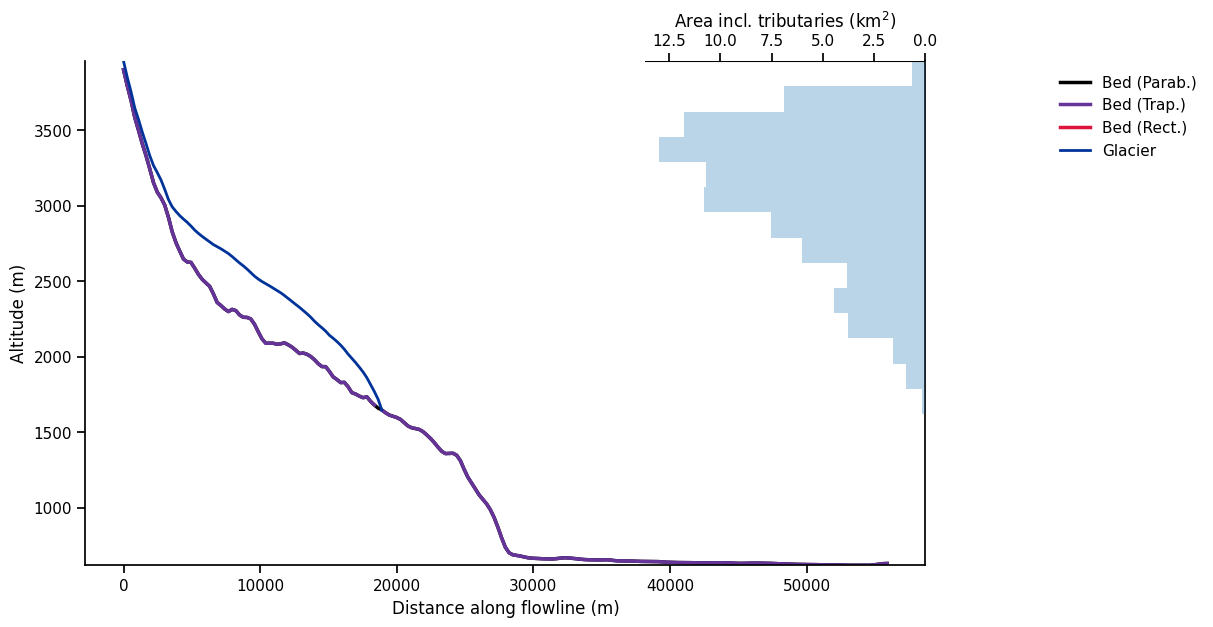

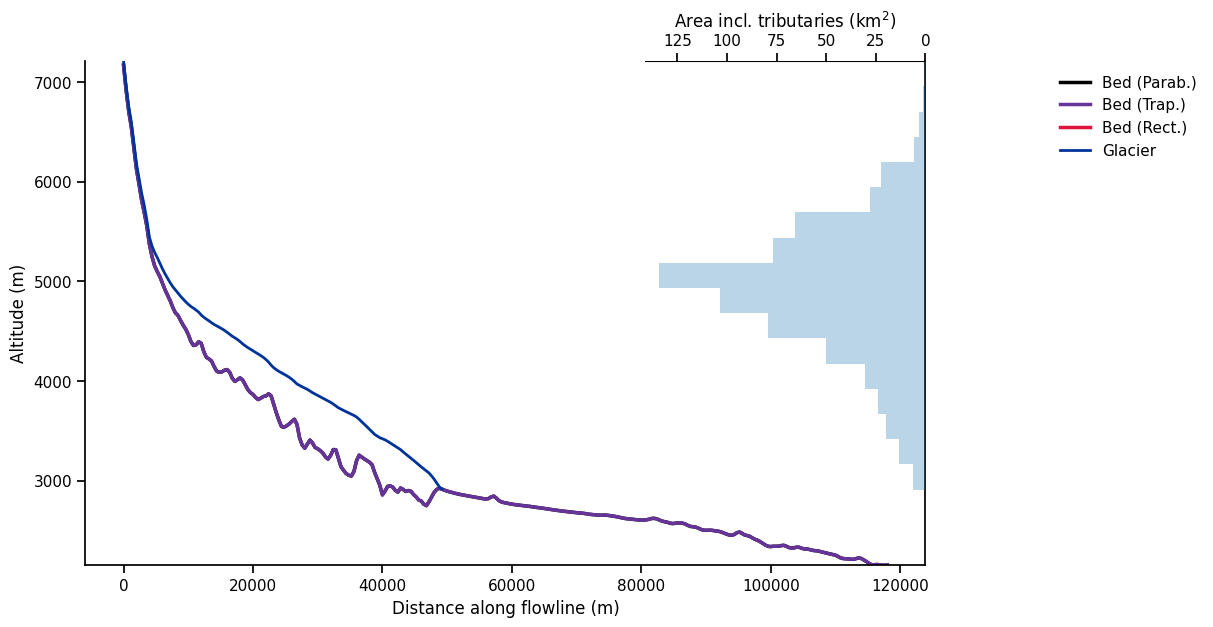

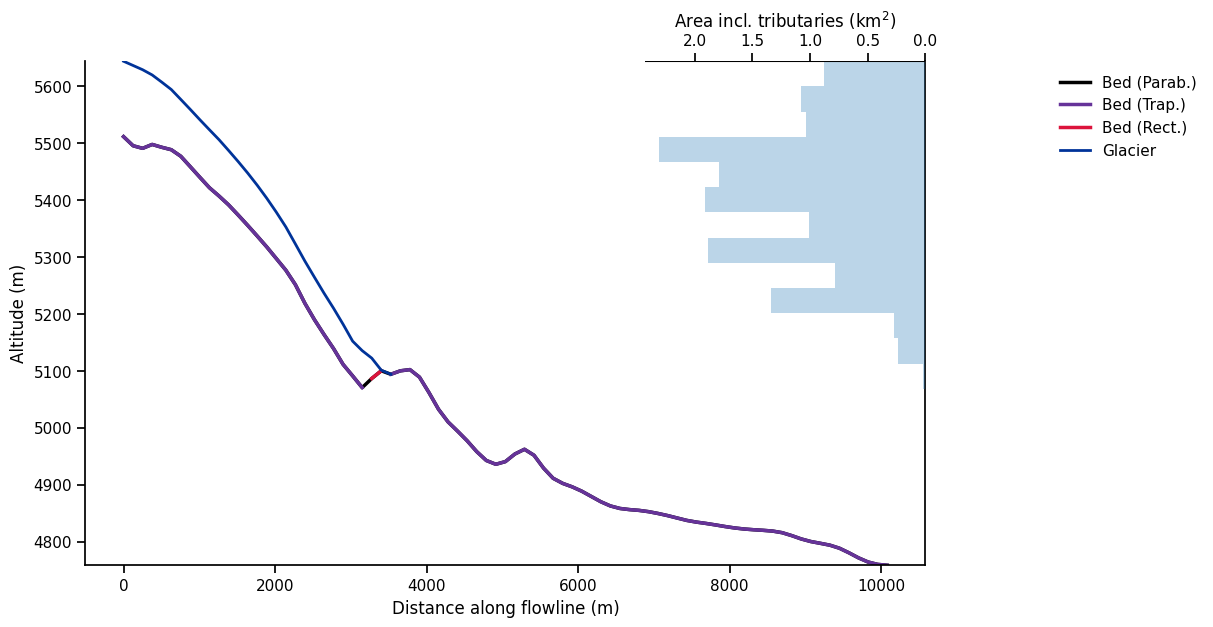

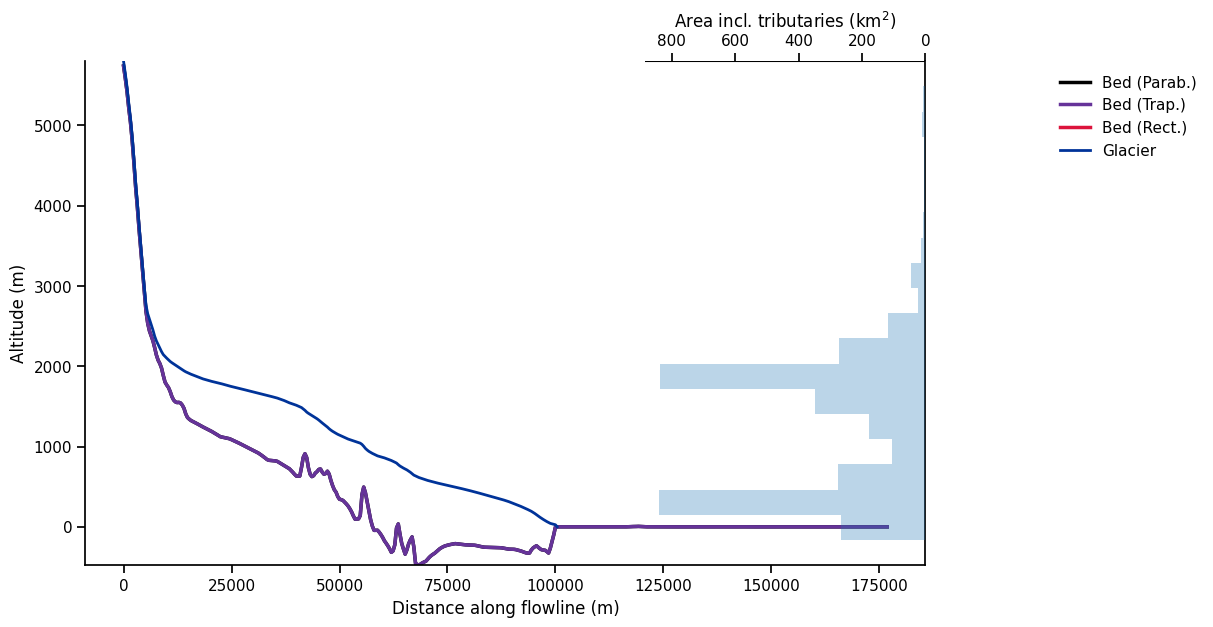

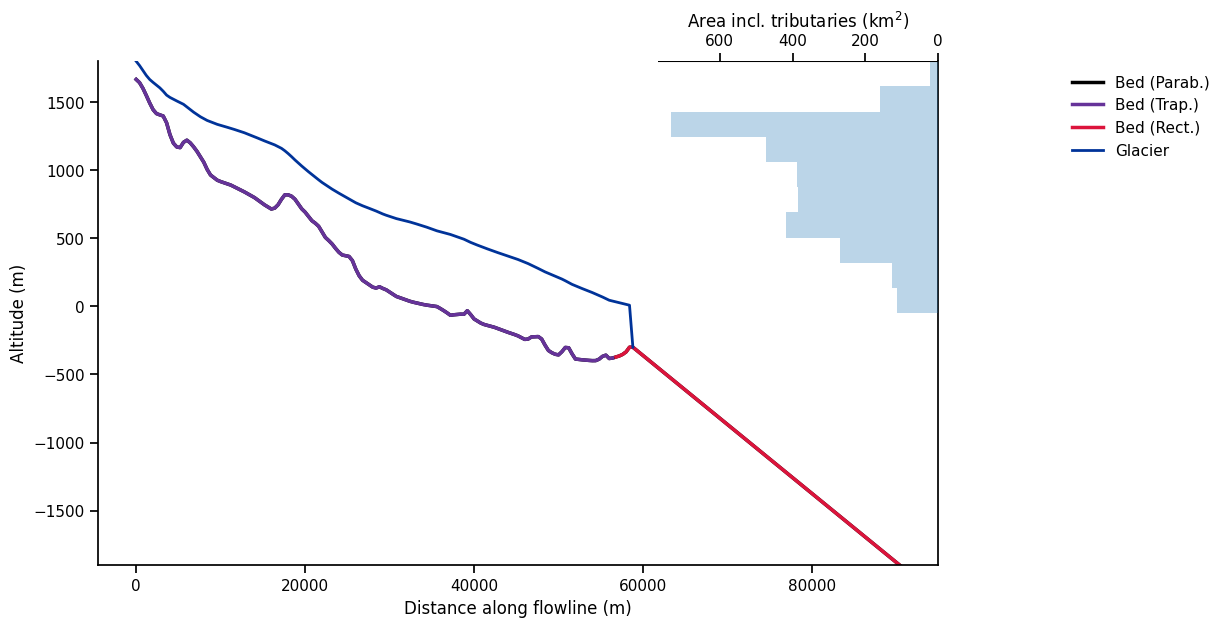

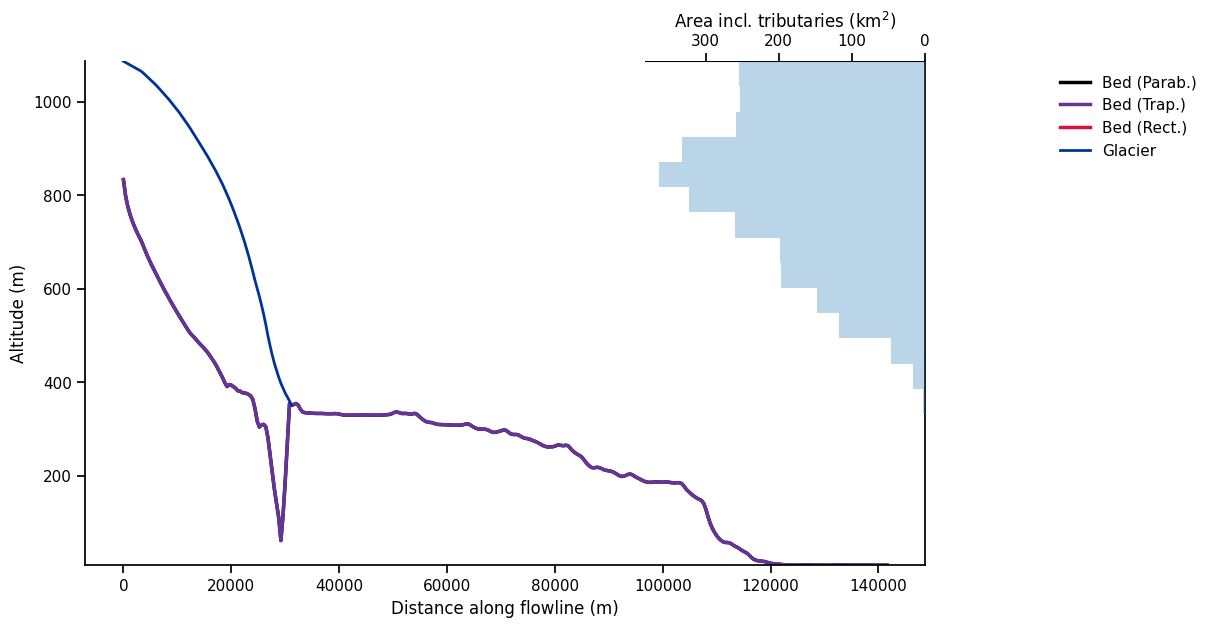

In [6]:
# We pick the same preprocessed gdirs as we will use for the actual projections later
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup'
# if it runs out of border -> do prepro_border=160
run = False
run_spinup = False
if run and run_spinup: 
    gdirs= workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_border=160, prepro_base_url=base_url)
else:
    gdirs= workflow.init_glacier_directories(rgi_ids) #, from_prepro_level=5, prepro_border=80, prepro_base_url=base_url)

for gdir in gdirs:
    fls = gdir.read_pickle('model_flowlines')
    graphics.plot_modeloutput_section(fls);
    print(gdir.name)

In [7]:
if run_spinup: 
    dict_delta_t_rgi_eq = {}
    file_id = f'_spinup'
    years = np.arange(2000) # it does not need to be in perfect equilibrium to select the delta_t

    for gdir, _r in zip(gdirs, rgi_ids):
        dict_delta_t = {}
        print(gdir.rgi_id)
        for delta_t in np.arange(-2.4,0.3,0.05): # this might need to be adapted for other glaciers 
            # We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
            try:
                temp_bias_ts = pd.Series(years * 0. + delta_t, index=years)
                tasks.run_with_hydro(gdir,  # Run on the selected glacier
                                     temp_bias_ts=temp_bias_ts,  # 200 yrs sufficientthe temperature bias to
                                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                                     output_filesuffix=file_id);  # an identifier for the output file, to read it later
                with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
                    # The last step of hydrological output is NaN (we can't compute it for this year)
                    ds = ds.isel(time=slice(0, -1)).load()
                    ratio = np.abs(1 - ds.volume_m3.isel(time=-1)/ds.volume_m3.isel(time=0)).values
                    if ds.isel(time=-1).volume_m3<0.7*ds.volume_m3.isel(time=0):
                        # we can stop, we don't need to look for even warmer temperatures... 
                        print(gdir.rgi_id, delta_t)
                        break 
                print(delta_t)
            except:
                ratio = 100000
            dict_delta_t[delta_t.round(2)] = ratio
        pd_delta_t = pd.DataFrame(dict_delta_t, index = ['rel_diff_v1/v0']).T
        print(pd_delta_t.min())
        delta_t_eq = pd_delta_t.idxmin().values[0]
        dict_delta_t_rgi_eq[gdir.rgi_id] = delta_t_eq
    
    
    ### spinup 
    for gdir in gdirs:
        print(gdir.rgi_id)
        delta_t_eq = dict_delta_t_rgi_eq[gdir.rgi_id]
        print(f'{gdir.rgi_id} - {gdir.name} need temperature bias of {delta_t_eq}°C to get into steady state with similar volume as volume from inventory date')
        #with plt.xkcd():
        delta_t = delta_t_eq
        years = np.arange(2000) # 1000 use longer time series to make sure it is in steady-state ... 
        temp_bias_ts = pd.Series(years * 0. + delta_t, index=years)
        temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)');

        # file identifier where the model output is saved
        file_id = '_spinup'

        # We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
        tasks.run_with_hydro(gdir,  # Run on the selected glacier
                             temp_bias_ts=temp_bias_ts,  # the temperature bias to apply to the average climate
                             run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                             y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                             store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                             output_filesuffix=file_id);  # an identifier for the output file, to read it later
    #dict_delta_t_rgi_eq.to_json('equilibrium_temp_bias.json')
    # Using a JSON string
    import json
    with open('idealised_equilibrium_temp_bias.json', 'w') as outfile:
        json_string = json.dumps(dict_delta_t_rgi_eq)
        outfile.write(json_string)
else:
    import json

    with open('idealised_equilibrium_temp_bias.json') as json_file:
        dict_delta_t_rgi_eq = json.load(json_file)
        print(dict_delta_t_rgi_eq)

{'RGI60-11.01450': -1.15, 'RGI60-13.54431': -0.4, 'RGI60-03.01710': -0.25, 'RGI60-04.06187': -2.05, 'RGI60-16.01251': -0.1, 'RGI60-01.13696': -0.6}


TODO:
- need to check the spinup temperature ... 

-1.15 0.8464908800000002
RGI60-11.01450
-0.4 1.5964908800000002
RGI60-13.54431
-0.1 1.89649088
RGI60-16.01251
-0.6 1.39649088
RGI60-01.13696
-0.25 1.74649088
RGI60-03.01710
-2.05 -0.053509119999999744
RGI60-04.06187


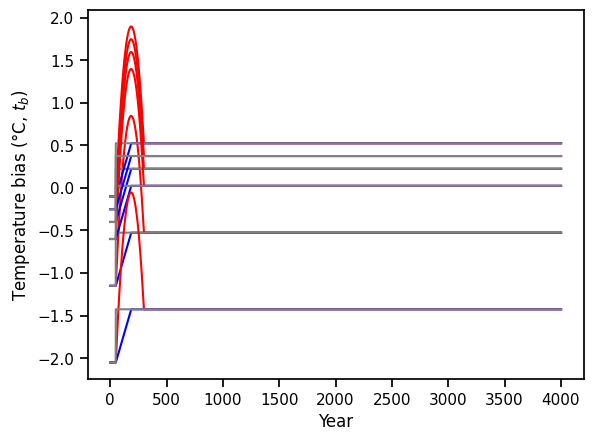

In [29]:
#f = np.array([-4.36202118e-12,  5.34151857e-09, -2.03858079e-06,
#              1.76227795e-04, 2.0097832e-02, -6.39048239e-01])
run = False
do_step_change = False
if run: 
    for gdir in gdirs: #gdirs[2:4]:
        delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]
        #if gdir.rgi_id == gdirs[-1].rgi_id:
        #    delta_t = delta_t+0.3 # ?????? 


        x = np.arange(0,250,1)
        
        ### added that because "t" was not defined -> does it work now???
        ny_s=50
        t0 = ny_s
        ny_e=250
        t1 = ny_e +ny_s
        a = -0.00010772
        b = 0.0024
        c = delta_t

        t = np.arange(t0, t1, 1)
        y = a * (t - t0) * (t - t1) + b * (t - t0) + c
        ####################
        #y= f[5] + f[4]*x + f[3]*x**2+f[2]*x**3+f[1]*x**4 + f[0]*x**5

       
        ys = np.concatenate([np.full(ny_s, y[0]), y, np.full(ny_e, y[-1])])
        temp_bias_ts = pd.Series(ys-(y[0]-delta_t), index=np.arange(0,250+ny_s+ny_e,1))
        temp_bias_ts = pd.concat([temp_bias_ts, pd.Series(index=np.arange(550,4002,1), dtype='float64')])
        temp_bias_ts.loc[550:] = temp_bias_ts.loc[549]
        temp_bias_ts.plot(color='red'); 

        ###
        #y2 = (y[-1]-y[0])/250*x + y[0]
        #ys2 = np.concatenate([np.full(ny_s, y2[0]), y2, np.full(ny_e, y[-1])])
        
        yr_max_os = temp_bias_ts.idxmax() - 50 
        x = np.arange(0,yr_max_os,1)
        y2 = (y[-1]-y[0])/yr_max_os*x + y[0]
        ys2 = np.concatenate([np.full(ny_s, y2[0]), y2, np.full(ny_e+250-yr_max_os, y[-1])])

        
        temp_bias_ts_lin = pd.Series(ys2-(y2[0]-delta_t), index=np.arange(0,yr_max_os+ny_s+ny_e+250-yr_max_os,1))
        #temp_bias_ts_lin = pd.Series(ys2-(y2[0]-delta_t), index=np.arange(0,250+ny_s+ny_e,1))
        temp_bias_ts_lin = pd.concat([temp_bias_ts_lin, pd.Series(index=np.arange(550,4002,1), dtype='float64')])
        temp_bias_ts_lin.loc[550:] = temp_bias_ts_lin.loc[549]
        temp_bias_ts_lin.plot(color='blue'); 

        
        temp_bias_step = np.concatenate([np.repeat(temp_bias_ts_lin.iloc[0], ny_s),
                                 np.repeat(temp_bias_ts_lin.iloc[-1], ny_e+250)])
        temp_bias_step = pd.Series(temp_bias_step, index=np.arange(0,250+ny_s+ny_e,1))
        temp_bias_step = pd.concat([temp_bias_step, pd.Series(index=np.arange(550,4002,1), dtype='float64')])
        temp_bias_step.loc[550:] = temp_bias_step.loc[549]
        temp_bias_step.plot(color='grey'); plt.xlabel('Year'); plt.ylabel(r'Temperature bias (°C, $t_b$)');
        
        print(temp_bias_ts.min(), temp_bias_ts.max())
        # .... need to use the correct temp_bias_ts ... 
        for add in ['']:
            # We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
            tasks.run_with_hydro(gdir,
                                 temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                                 run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                                 y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                 store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                                 init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                                 output_filesuffix=f'_oversh_temp{add}');  # an identifier for the output file, to read it later

            # linear temp. change
            tasks.run_with_hydro(gdir,
                                 temp_bias_ts=temp_bias_ts_lin,  # the temperature bias timeseries we just created
                                 run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                                 y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                 store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                                 init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                                 output_filesuffix= f'_lin_temp{add}');  # an identifier for the output file, to read it later
            if do_step_change:
                # step temp. change
                #
                tasks.run_with_hydro(gdir,
                                     temp_bias_ts=temp_bias_step,  # the temperature bias timeseries we just created
                                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                                     init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                                     output_filesuffix= f'_step_temp{add}');  # an identifier for the output file, to read it later
        print(gdir.rgi_id)

In [24]:
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']

labels_nice_dict = {'melt_off_glacier': 'melt off glacier',
                    'melt_on_glacier': 'melt on glacier',
                    'liq_prcp_off_glacier': 'liquid precipitation off glacier',
                    'liq_prcp_on_glacier': 'liquid precipitation on glacier'}

time
0.0       3.368978e+12
1.0       3.369044e+12
2.0       3.369112e+12
3.0       3.369180e+12
4.0       3.369248e+12
              ...     
3996.0    3.323703e+12
3997.0    3.323703e+12
3998.0    3.323703e+12
3999.0    3.323703e+12
4000.0    3.323703e+12
Length: 4001, dtype: float64

(0.7309496347558632, 0.8394771241830065, 0.9213225682429834)

RGI60-11.01450 7 9
RGI60-11.01450 7 9
RGI60-13.54431 7 9
RGI60-13.54431 7 9
RGI60-16.01251 9 11
RGI60-16.01251 9 11
RGI60-01.13696 5 7
RGI60-01.13696 5 7
RGI60-03.01710 4 6
RGI60-03.01710 4 6
RGI60-04.06187 4 6
RGI60-04.06187 4 6


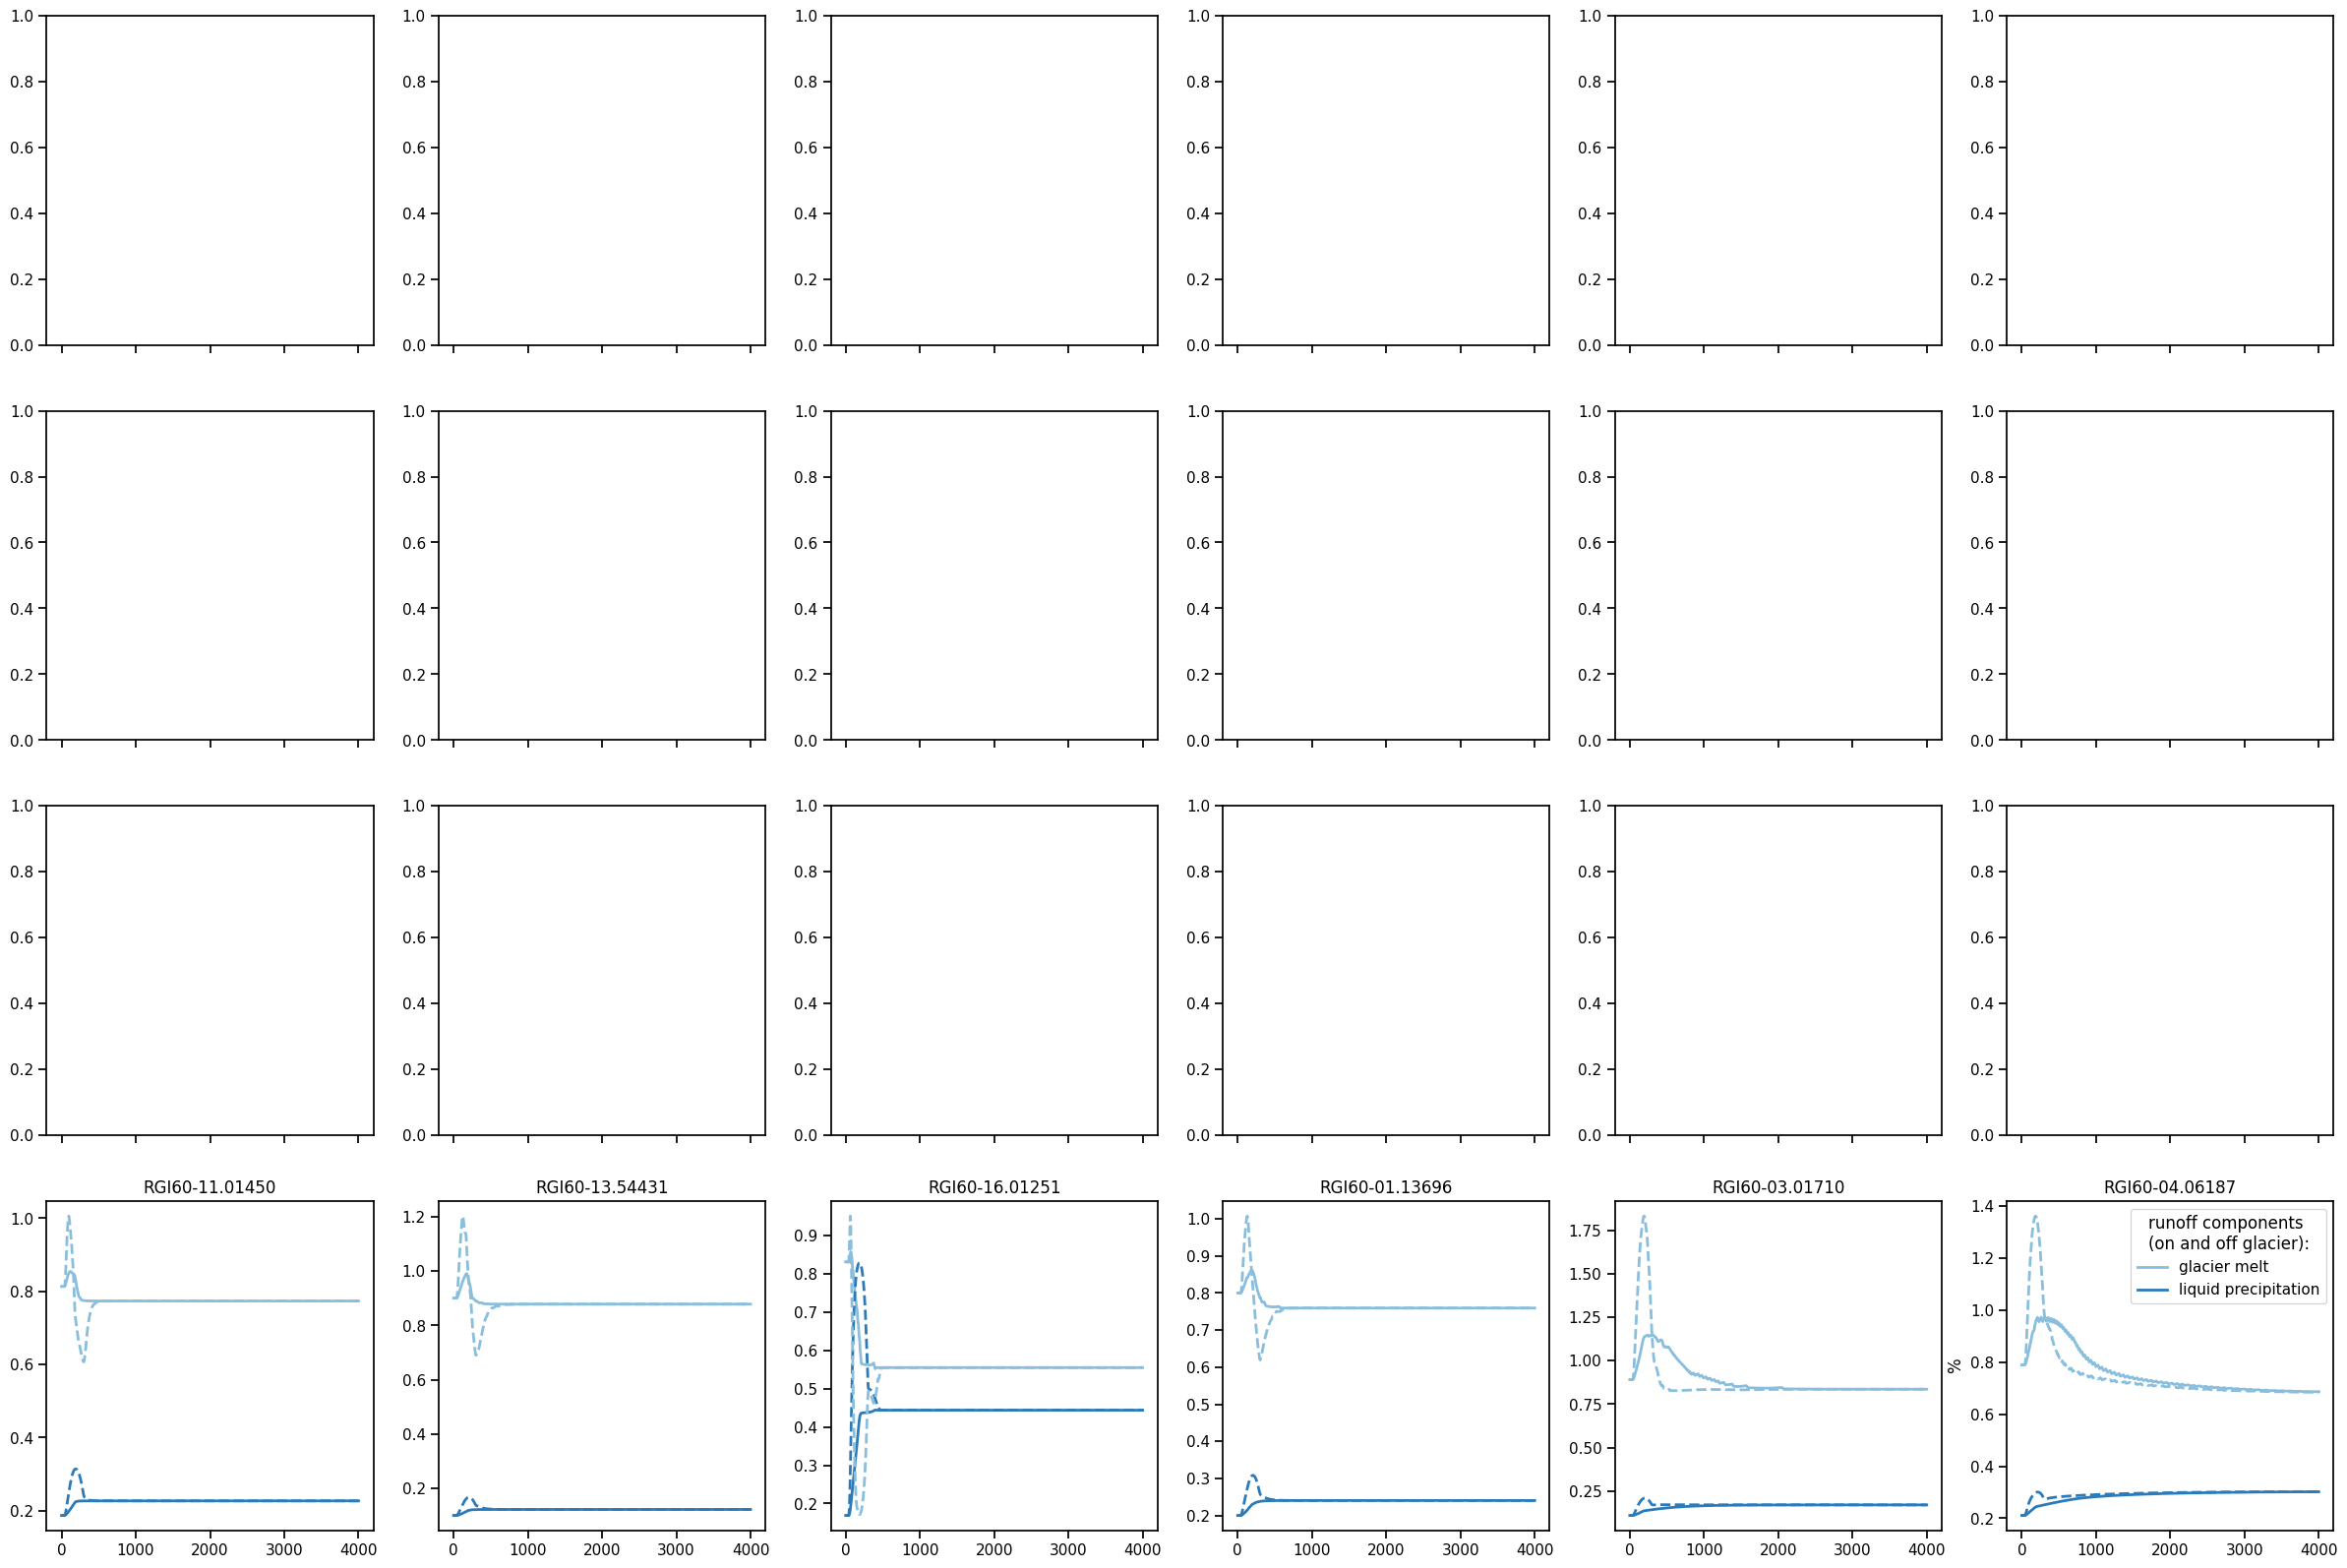

In [125]:
roll = 21

ds_d = {}
ds_lin_d = {}
#ds_step_d = {}

df_runoff_d = {}
df_lin_runoff_d = {}
#df_step_runoff_d = {}

df_runoff_d_dry = {}
df_lin_runoff_d_dry = {}
#df_step_runoff_d_dry = {}
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(30, 20), sharex=True)
axs = axs.flatten()
axs_s = axs[-6:]
for j,gdir in enumerate(gdirs):
    with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_oversh_temp')) as ds:
        # The last step of hydrological output is NaN (we can't compute it for this year)
        ds = ds.isel(time=slice(0, -1)).load()

    with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_lin_temp')) as ds_lin:
        ds_lin = ds_lin.isel(time=slice(0, -1)).load()
    if do_step_change:
        with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_step_temp')) as ds_step:
            ds_step = ds_step.isel(time=slice(0, -1)).load()

    runoff_vars_monthly = ['melt_off_glacier_monthly',
                           'melt_on_glacier_monthly',
                           'liq_prcp_off_glacier_monthly',
                           'liq_prcp_on_glacier_monthly']

    labels_nice_dict = {'melt_off_glacier_monthly': 'melt off glacier',
                        'melt_on_glacier_monthly': 'melt on glacier',
                        'liq_prcp_off_glacier_monthly': 'liquid precipitation off glacier',
                        'liq_prcp_on_glacier_monthly': 'liquid precipitation on glacier'}
    sel_vars_m = [v for v in ds.variables if 'month_2d' in ds[v].dims]
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]

    
    ds_lin_d[gdir.rgi_id] = ds_lin
    #ds_step_d[gdir.rgi_id] = ds_step
    ds_d[gdir.rgi_id] = ds
    
    for _d,_f in zip([ds,ds_lin], #,ds_step],
                     [df_runoff_d,df_lin_runoff_d]): #,df_lin_runoff_d_dry]):
                      
                                          
        df_annual = _d[runoff_vars].to_dataframe()
        # Select only the runoff variables
        # Convert them to megatonnes (instead of kg)
        df_runoff = df_annual[runoff_vars] * 1e-9
        # We smooth the output, which is otherwize noisy because of area discretization
        df_runoff = df_runoff.rolling(roll, center=True, min_periods=1).mean()
        df_runoff = df_runoff.rename(columns=labels_nice_dict)
                      
        _f[gdir.rgi_id] = df_runoff

    for _d,_f in zip([ds,ds_lin], #,ds_step],
                 [df_runoff_d_dry,df_lin_runoff_d_dry]): #,df_lin_runoff_d_dry]):   
        # todo change the numbers 
        m_last = dry_last_month_glacier_d[gdir.rgi_id]
        m_first = m_last-2
        print(gdir.rgi_id, m_first, m_last)
        df_summer = _d[runoff_vars_monthly].sel(month_2d=slice(m_first,m_last)).sum(dim='month_2d').to_dataframe()
        # Convert them to megatonnes (instead of kg)
        df_runoff_sum = df_summer[runoff_vars_monthly] * 1e-9
        # We smooth the output, which is otherwize noisy because of area discretization
        df_runoff_sum = df_runoff_sum.rolling(roll, center=True, min_periods=1).mean()
        _f[gdir.rgi_id] = df_runoff_sum#.sum(axis=1)
    #df_runoff_d[gdir.rgi_id] = df_runoff
    #df_step_runoff_d[gdir.rgi_id] = df_step_runoff
    #df_lin_runoff_d[gdir.rgi_id] = df_lin_runoff
    roll=21
    ds_lin_r = ds_lin.rolling(time=roll, center=True, min_periods=1).mean().dropna(dim='time')
    ds_r = ds.rolling(time=roll, center=True, min_periods=1).mean().dropna(dim='time')



    axs_s[j].plot((ds_lin_r.melt_off_glacier + ds_lin_r.melt_on_glacier)/ds_lin_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10], 
                  label='glacier melt', lw=2,  ls='-', color=sns.color_palette('Blues')[2])
    axs_s[j].plot(((ds_lin_r.liq_prcp_on_glacier + ds_lin_r.liq_prcp_off_glacier))/ds_lin_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10],
                  label='liquid precipitation', ls='-', color=sns.color_palette('Blues')[-2], lw=2)
    axs_s[j].set_title(gdir.rgi_id)
    plt.legend()
    # title='runoff components\n(on and off glacier):
    axs_s[j].plot(((ds_r.liq_prcp_on_glacier + ds_r.liq_prcp_off_glacier))/ds_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10],
                  label='liquid precipitation', ls='--', color=sns.color_palette('Blues')[-2], lw=2)
    axs_s[j].plot((ds_r.melt_off_glacier + ds_r.melt_on_glacier)/ds_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10], 
                  label='glacier melt', lw=2,  ls='--', color=sns.color_palette('Blues')[2])
    plt.ylabel('%')

In [131]:
num_dict = {
    0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j',
    10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's',
    19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'
}

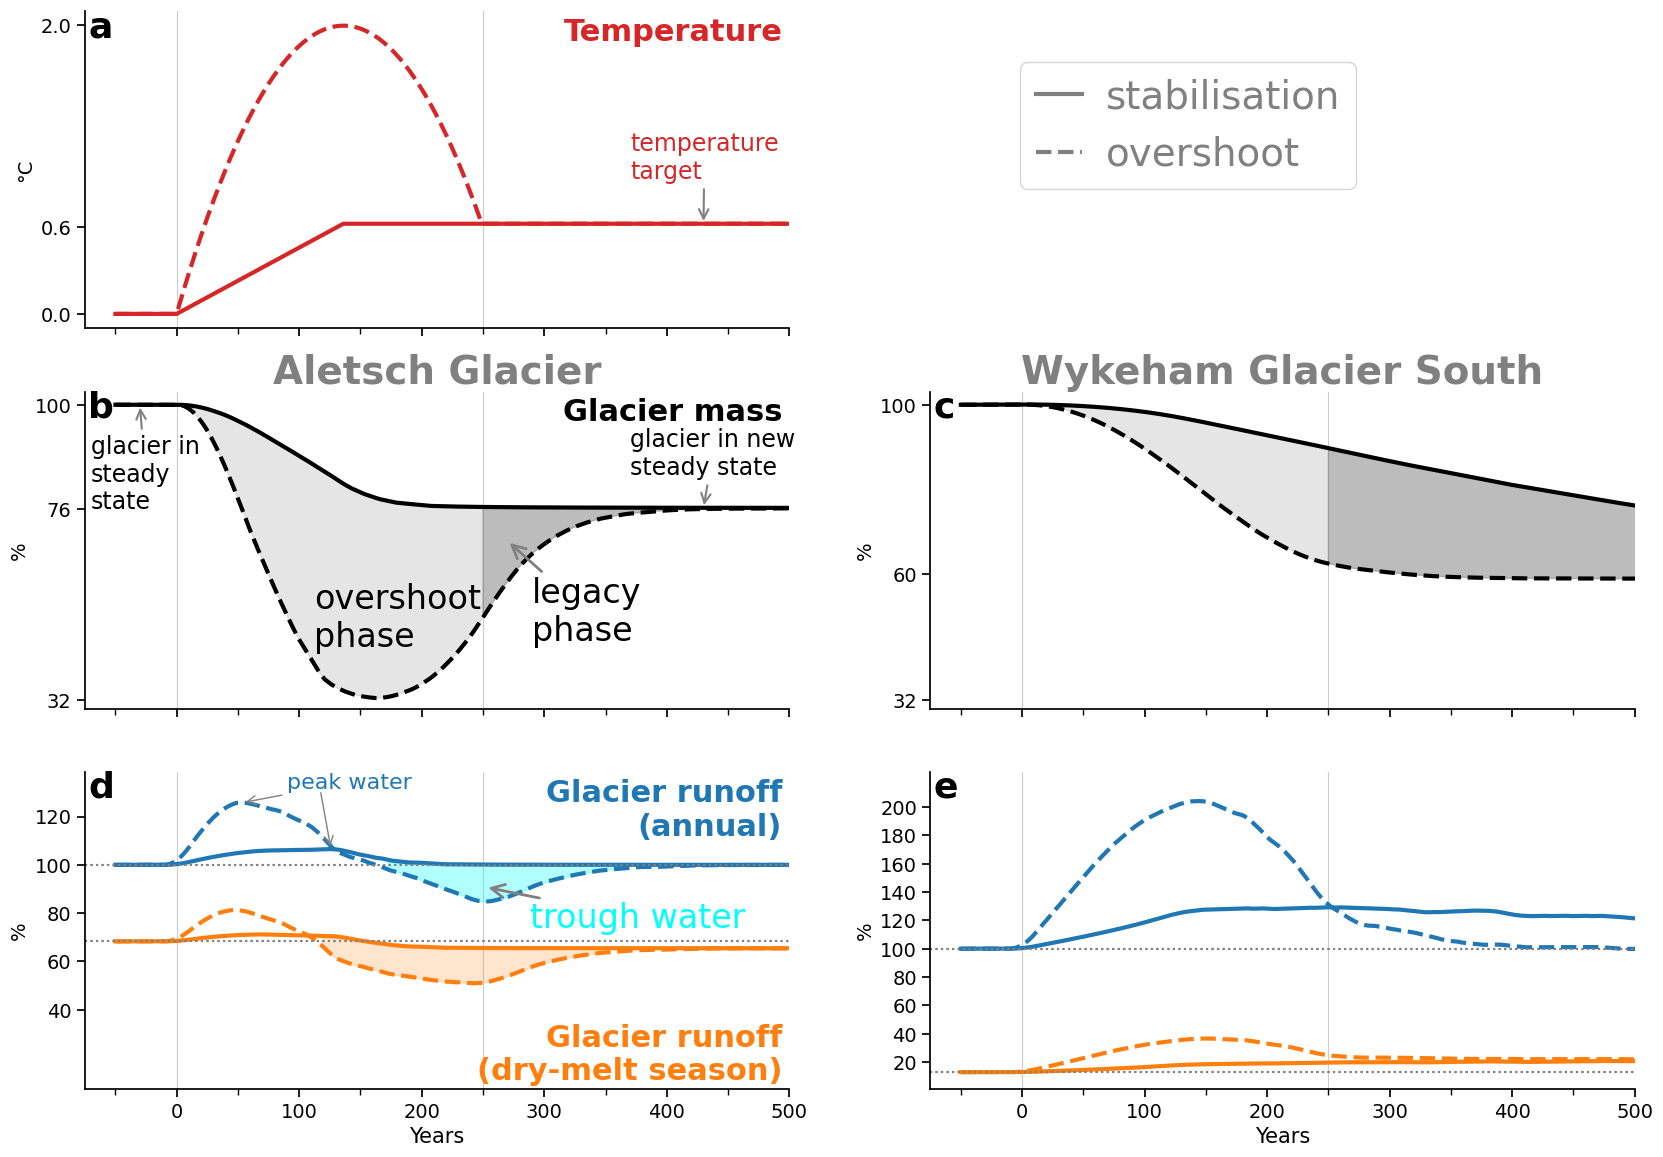

In [181]:
gdirs_sel_fig1 = [gdirs[0],gdirs[-2]]

with_step_ch = False
plt.rc('font', size=26)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 14), sharex=True)
axs = axs.flatten()

j = 0

#ds.length_m.plot(ax=axs[1]);
if with_step_ch:
    temp_bias_step.plot(ax=axs[0], c='C3', ls=':', lw=3, label='step change');
(temp_bias_ts_lin-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', ls='-', lw=3, label='stabilisation');
(temp_bias_ts-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', label='overshoot', lw=3, ls='--');
axs[0].text(0.99, 0.98, 'Temperature', weight='bold',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=22, color='C3')
leg = axs[0].legend(fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6,
                    loc = 'upper left', bbox_to_anchor=(1.3,0.9), ncol=1)
axs[0].set_xlabel(''); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

for jj in np.arange(0,len(leg.get_lines()),1):
    leg.get_lines()[jj].set_color('grey')
    leg.get_texts()[jj].set_color('grey')
    

axs[0].annotate('temperature\ntarget',(480,temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0]),
                xytext=(420,(temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0])*1.5),
                color='C3',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

##
for j,gdir in enumerate(gdirs_sel_fig1): 
    ds = ds_d[gdir.rgi_id]
    ds_lin = ds_lin_d[gdir.rgi_id]

    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff_lin = df_lin_runoff_d[gdir.rgi_id]

    df_runoff_dry = df_runoff_d_dry[gdir.rgi_id]
    df_runoff_dry_lin = df_lin_runoff_d_dry[gdir.rgi_id]
    
    init_vol = ds_lin.volume_m3.isel(time=0)
    if j==0:
        axs[2+j].text(0.99, 0.98, 'Glacier mass',
                 ha='right', va='top', transform=axs[2+j].transAxes, 
                fontsize=22, color='black', weight='bold')
    if with_step_ch:
        (100*ds_lin.volume_m3/init_vol).plot(ax=axs[2+j], c='black', ls=':');

    (100*ds_lin.volume_m3/init_vol).plot(ax=axs[2+j], c='black', ls ='-' , lw=3);
    (100*ds.volume_m3/init_vol).plot(ax=axs[2+j], c='black', ls='--', lw=3);
    axs[2+j].set_ylabel('')
    #axs[1].set_title('Glacier mass', fontsize=22)
    eq0 = (100*ds.volume_m3/init_vol).isel(time=0)
    eq1 = (100*ds.volume_m3/init_vol).isel(time=-1)
    if j==0:
        axs[2+j].annotate('glacier in\nsteady\nstate',(20,eq0), xytext=(-20,eq0*0.76), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

        axs[2+j].annotate('glacier in new\nsteady state',(480,eq1), xytext=(420,eq1*1.1), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

    t = 0 #np.abs((temp_bias_ts-temp_bias_ts_lin.max())).iloc[:200].idxmin()
    axs[2+j].fill_between(ds_lin.time.sel(time=slice(t,ds_lin.time.values[-1])), (100*ds.sel(time=slice(t,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(t,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.2, color='grey')
    if j==0:
        axs[2+j].annotate('overshoot\nphase', #additional\nwarming\nreduces\nice',
                          (162,eq1*0.58),color='black',
                           fontsize=24)

    axs[2+j].fill_between(ds_lin.time.sel(time=slice(300,ds_lin.time.values[-1])), (100*ds.sel(time=slice(300,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(300,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.4, color='grey')
    if j==0:
        axs[2+j].annotate('legacy\nphase', # past warming reduces ice
                          (320,eq1*0.9), xytext=(340,eq1*0.6), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=24) 
        ### temporarily irreversible 
        axs[4+j].text(0.99, 0.98, 'Glacier runoff\n(annual)',
                 ha='right', va='top', transform=axs[4+j].transAxes, 
                fontsize=22, color='C0', weight='bold')
    init_runoff = df_runoff.sum(axis=1).iloc[0]
    if with_step_ch:
        (100*df_runoff_step.sum(axis=1)/init_runoff).plot(ax=axs[4+j], label = 'Annual runoff', c='C0', ls=':');
    (100*df_runoff_lin.sum(axis=1)/init_runoff).plot(ax=axs[4+j], label = 'Annual runoff', c='C0', ls='-', lw=3);
    (100*df_runoff.sum(axis=1)/init_runoff).plot(ax=axs[4+j], label = 'Annual runoff', c='C0', ls='--', lw=3);

    axs[4+j].axhline((100*df_runoff.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    axs[4+j].axhline((100*df_runoff_lin.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    #plt.ylabel('Runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');

    #axs[2].fill_between(df_runoff.index,
    #                 df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).values, alpha = 0.3, color='C0')

    diff = (-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1))
    diff_initial = -df_runoff.sum(axis=1).iloc[0] + df_runoff.sum(axis=1) 
    axs[4+j].fill_between(df_runoff_lin.index, (100*df_runoff_lin.sum(axis=1).where((diff<-5)&(diff_initial<-5))/init_runoff),
                                            (100*df_runoff.sum(axis=1).where((diff<-5)&(diff_initial<-5))/init_runoff), alpha=0.3, color='cyan')
    pw = (100*df_runoff.sum(axis=1).max()/init_runoff)
    tw = (100*df_runoff.sum(axis=1).min()/init_runoff)
    axs[4+j].set_ylim([(100*df_runoff_sum.sum(axis=1).min()*0.95/init_runoff),pw*1.1])
    pw_ind = df_runoff.sum(axis=1).idxmax()
    m = 4+j

    if j==0:
        axs[4+j].annotate('peak water',(pw_ind,pw), xytext=(pw_ind*1.35,pw*1.1),
                        xycoords='data', textcoords='data', va ='top',
                        color='C0',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
        pw_lin = (100*df_runoff_lin.sum(axis=1).max()/init_runoff)
        pw_ind_lin =  df_runoff_lin.sum(axis=1).idxmax()
        axs[4+j].annotate('',(pw_ind_lin,pw_lin), xytext=(pw_ind_lin*0.95,pw_lin*1.23),
                        xycoords='data', textcoords='data',
                        color='C0',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
        tw_ind = df_runoff.sum(axis=1).idxmin()

        axs[4+j].annotate('trough water',(tw_ind,tw*1.07), xytext=(tw_ind*1.12,tw*0.92),
                     xycoords='data', textcoords='data', color='cyan',
                        va='center',ha='left',
                   arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=24)

        #plt.legend()
        axs[m].text(0.99, 0.01, 'Glacier runoff\n(dry-melt season)', # here for Aletsch glacier (i.e., driest months of entire RHONE basin)
                 ha='right', va='bottom', transform=axs[m].transAxes, 
                fontsize=22, color='tab:orange', weight='bold')
    if with_step_ch:
        (100*df_runoff_dry_step/init_runoff).sum(axis=1).plot(ax=axs[m], c='tab:orange', ls=':');
    (100*df_runoff_dry_lin.sum(axis=1)/init_runoff).plot(ax=axs[m],  c='tab:orange', ls='-',lw=3);
    (100*df_runoff_dry.sum(axis=1)/init_runoff).plot(ax=axs[m], c='tab:orange', ls='--', lw=3);
    axs[m].axhline((100*df_runoff_dry.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')
    axs[m].axhline((100*df_runoff_dry_lin.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')

    #tw_ind_dry = df_runoff_dry.sum(axis=1).idxmin()
    #axs[m].annotate('',(tw_ind_dry,tw_ind_dry*1.01), xytext=(tw_ind_dry*1.2,tw_ind_dry*1.3),
    #             xycoords='data', textcoords='data', color='cyan',
    #                va='bottom',ha='left',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=20)

    #axs[m].fill_between(df_runoff_dry.sum(axis=1).index,
    #                    df_runoff_dry.sum(axis=1).iloc[0],
    #                    df_runoff_dry.sum(axis=1).values, alpha = 0.3, color='tab:orange')

    diff = (-df_runoff_dry_lin.sum(axis=1)+df_runoff_dry.sum(axis=1))
    diff_initial = -df_runoff_dry_lin.sum(axis=1).iloc[0] + df_runoff_dry.sum(axis=1) 
    axs[4+j].fill_between(df_runoff_dry_lin.index, (100*df_runoff_dry_lin.sum(axis=1).where((diff<-5)&(diff_initial<-5))/init_runoff),
                                                  (100*df_runoff_dry.sum(axis=1).where((diff<-5)&(diff_initial<-5))/init_runoff), alpha=0.2, color='tab:orange') #, label='')


    #leg = axs[3].legend(title='Melt-season glacier runoff', title_fontsize=22, frameon=False)#, fontsize=20)
    #leg.get_title().set_color('C4')

    axs[m].set_ylim([axs[m].get_ylim()[0]*0.6, axs[m].get_ylim()[1]])
    #plt.ylabel('Melt-season runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
    #plt.plot(df_runoff_sum.index, np.repeat(df_runoff_sum.sum(axis=1).iloc[0], len(df_runoff_sum)),
    #         c='cyan', ls='-.',lw=0.4)
    #ax.set_xticks([])
    num_text_x = 0.005
    num_text_y = 0.92
    fs_ticks=14
    axs[0].set_yticks([(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      [(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      fontsize=fs_ticks)
    axs[0].set_ylabel('°C', fontsize=fs_ticks)
    if j==0:
        axs[2+j].set_yticks([int((100*ds.volume_m3/init_vol).min().round(0).values),
                             int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                          [int((100*ds.volume_m3/init_vol).min().round(0).values), int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                            fontsize=fs_ticks)
    else:
        axs[2+j].set_yticks([int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                             int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                          [int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                           int((100*ds.volume_m3/init_vol).min().round(0).values), 100],
                            fontsize=fs_ticks)
    axs[2+j].set_ylim([30,103])
    
    axs[2+j].set_ylabel('%', fontsize=fs_ticks)
    axs[4+j].set_ylabel('%', fontsize=fs_ticks)
    if j==0:
        axs[4+0].set_yticks([40,60,80,100,120],[40,60,80,100,120], fontsize=fs_ticks)
    else:
        axs[4+1].set_yticks([20,40,60,80,100,120,140,160,180, 200],
                            [20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)


    #plt.tight_layout();
    axs[4+j].set_xticks([50,150,250,350,450,550], [0,100,200,300,400,500], fontsize=fs_ticks)
    axs[4+j].set_xlabel('Years', fontsize=fs_ticks+1); #axs[0].set_ylabel('Temperature bias (°C)');
# reset the time axis to start at zero when the temp. changes are applied
for jj,ax in enumerate([axs[0], axs[2], axs[3], axs[4], axs[5]]):
    #ax.set_yticks([]);
    ax.set_xticks([],[])
    ax.text(num_text_x, num_text_y,
            num_dict[jj], fontsize=26, transform=ax.transAxes, weight='bold')
    ax.axvline(300, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlim([-25,525])
for j in [0,1]:
    axs[4+j].set_xticks([50,150,250,350,450,550], [0,100,200,300,400,500], fontsize=fs_ticks)
    axs[4+j].set_xlabel('Years', fontsize=fs_ticks+1); #axs[0].set_ylabel('Temperature bias (°C)');
    if gdirs_sel_fig1[j].rgi_id == 'RGI60-11.01450':
        name = 'Aletsch Glacier'
        axs[2+j].set_title(name, weight='bold', fontsize=28, color = 'grey')
    else:
        axs[2+j].set_title(gdirs_sel_fig1[j].name, weight='bold', fontsize=28, color = 'grey')

fig.delaxes(axs[1])
plt.savefig('overshoot_conceptual_model_variant_july_2024.pdf')
plt.savefig('overshoot_conceptual_model_variant_july_2024.png')

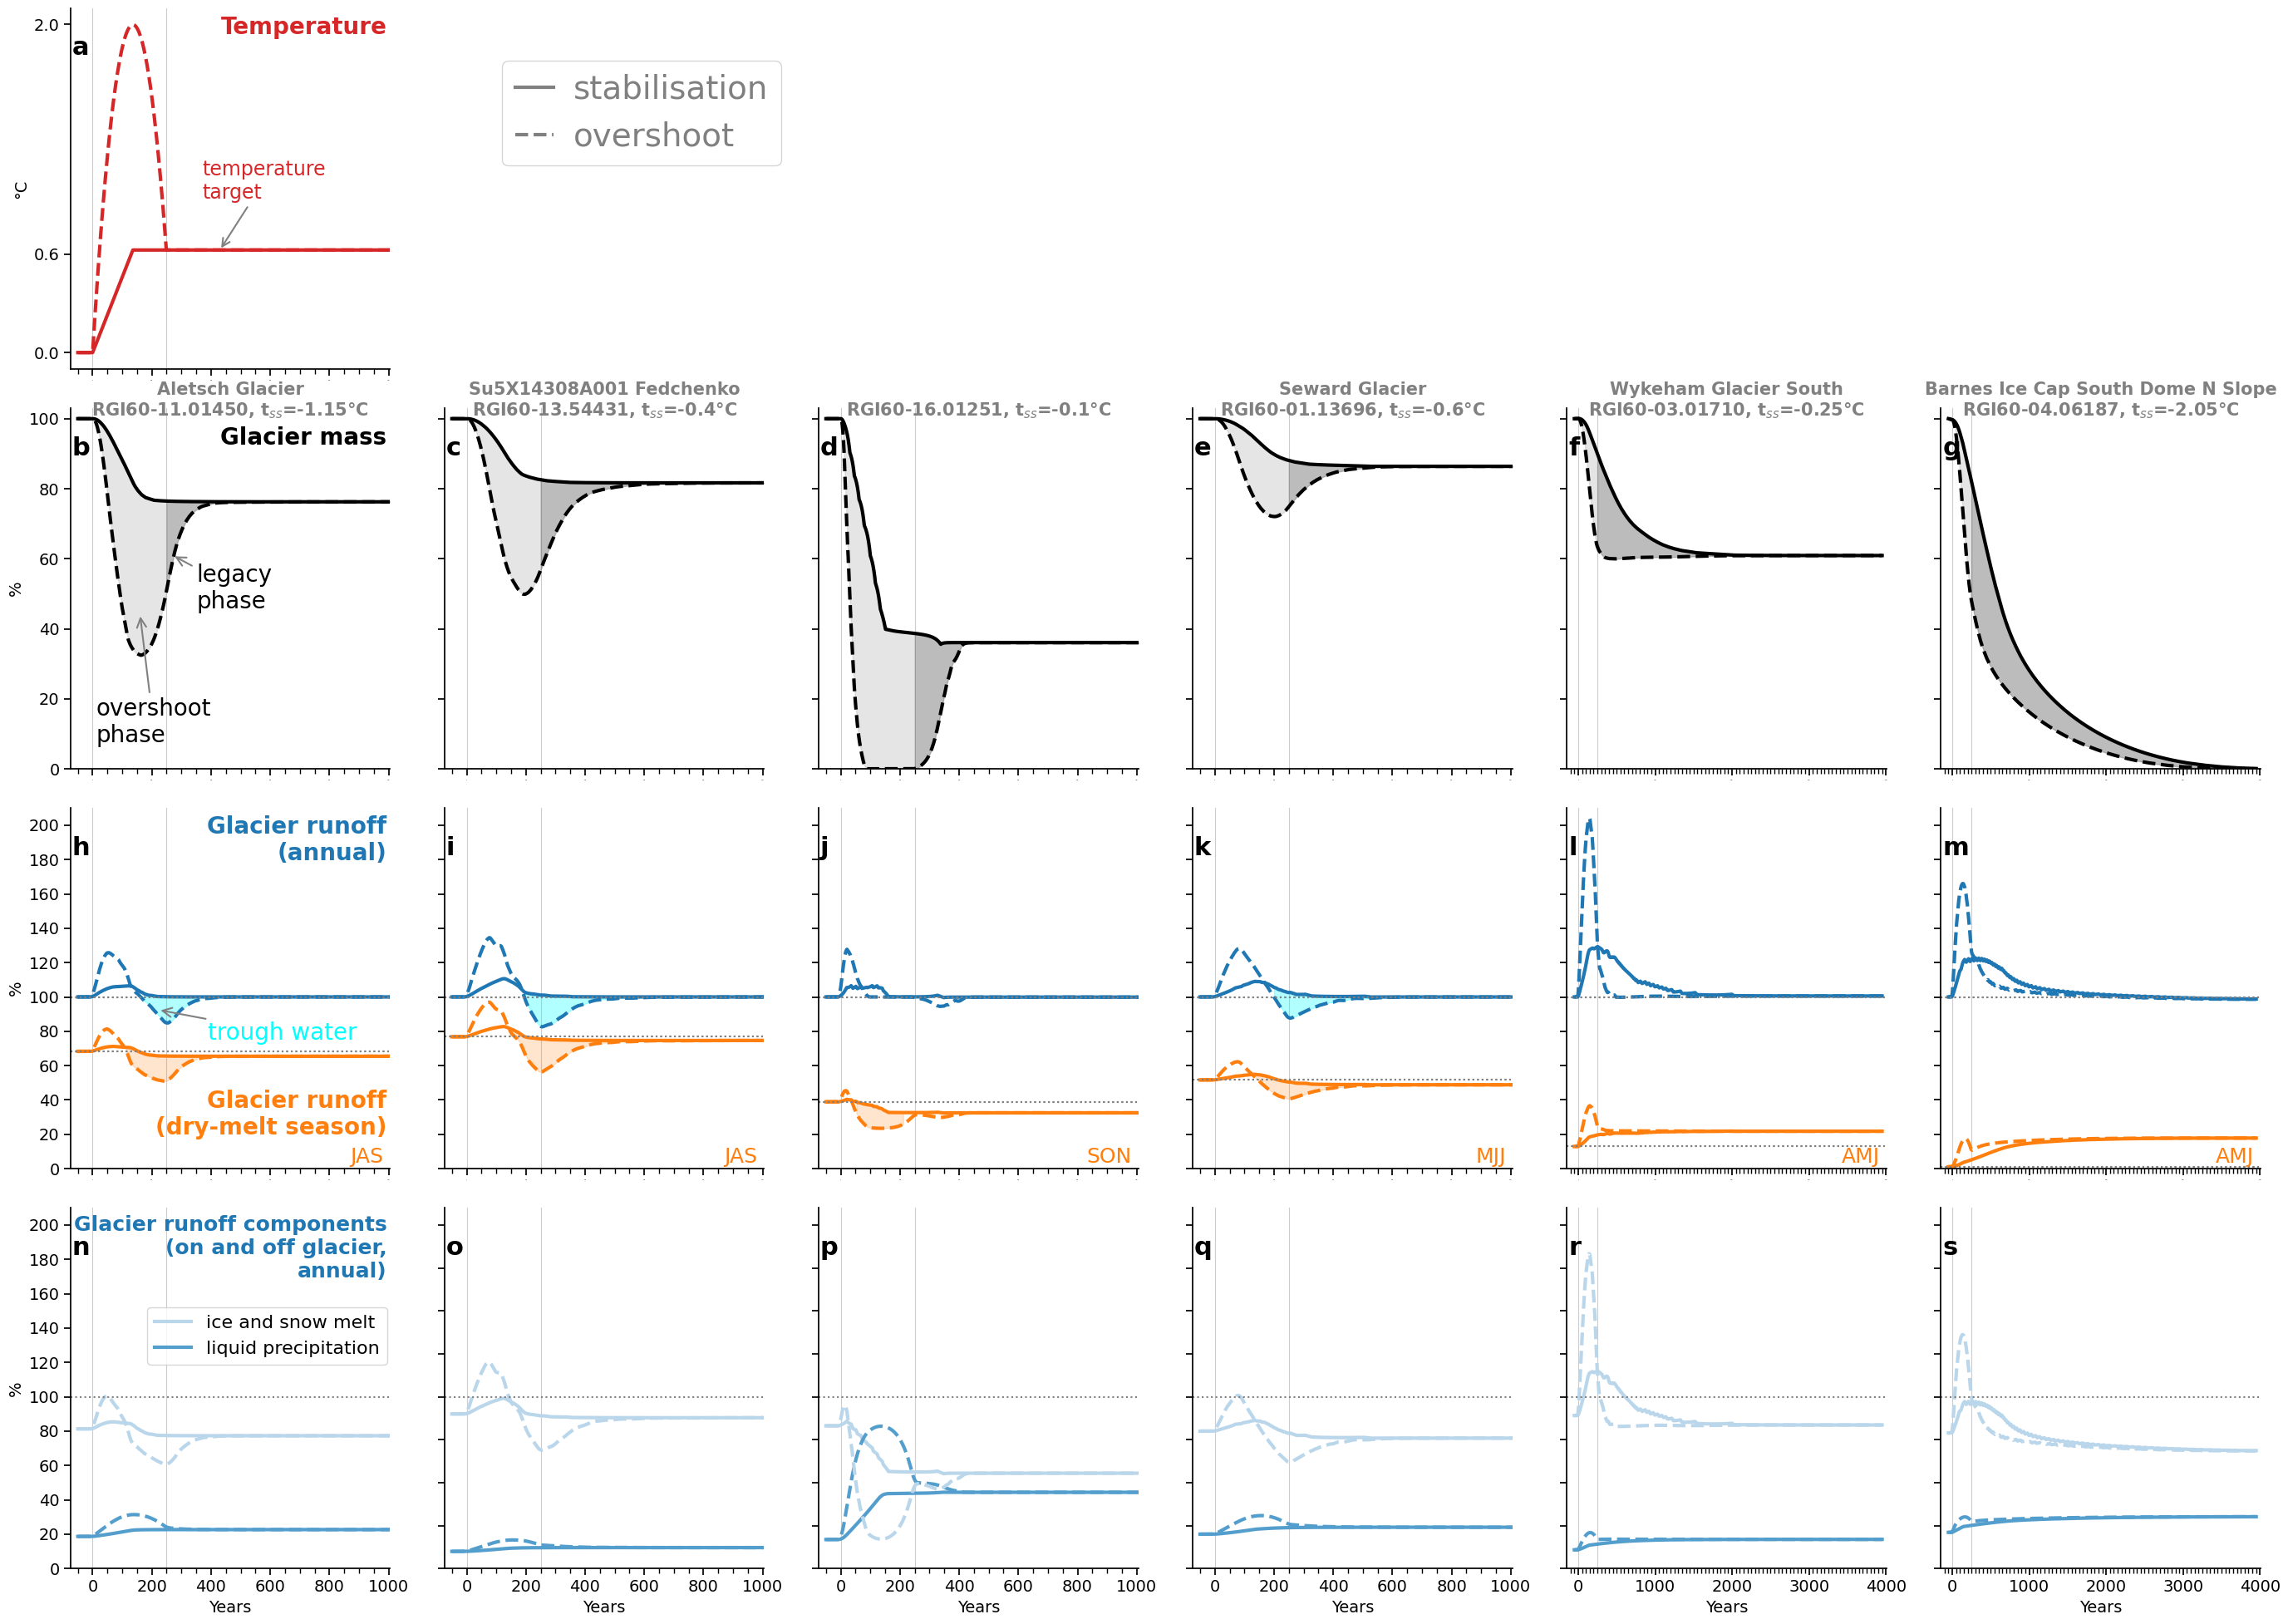

In [180]:
with_step_ch = False
fig_1_opt = False

plt.rc('font', size=22)
fs_ticks=14

ncols=6

fig, axs = plt.subplots(nrows=4, ncols=ncols, figsize=(28, 20)) #, sharex=True)
axs = axs.flatten()

j = 0

#ds.length_m.plot(ax=axs[1]);
if with_step_ch:
    temp_bias_step.plot(ax=axs[0], c='C3', ls=':', lw=3, label='step change');
(temp_bias_ts_lin-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', ls='-', lw=3, label='stabilisation');
(temp_bias_ts-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', label='overshoot', lw=3, ls='--');
axs[0].text(0.99, 0.98, 'Temperature', weight='bold',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=20, color='C3')
handles, labels = axs[0].get_legend_handles_labels()
#axs[0].get_legend().remove()

axs[0].set_xlabel(''); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

axs[0].annotate('temperature\ntarget',(480,temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0]),
                xytext=(420,(temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0])*1.5),
                color='C3',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

##
for j,gdir in enumerate(gdirs): 
    ds = ds_d[gdir.rgi_id]
    ds_lin = ds_lin_d[gdir.rgi_id]

    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff_lin = df_lin_runoff_d[gdir.rgi_id]

    df_runoff_dry = df_runoff_d_dry[gdir.rgi_id]
    df_runoff_dry_lin = df_lin_runoff_d_dry[gdir.rgi_id]
    
    init_vol = ds_lin.volume_m3.isel(time=0)
    if j==0:
        axs[ncols+j].text(0.99, 0.95, 'Glacier mass',
                 ha='right', va='top', transform=axs[ncols+j].transAxes, 
                fontsize=20, color='black', weight='bold')
    if with_step_ch:
        (100*ds_lin.volume_m3/init_vol).plot(ax=axs[ncols+j], c='black', ls=':');

    (100*ds_lin.volume_m3/init_vol).plot(ax=axs[ncols+j], c='black', ls ='-' , lw=3);
    (100*ds.volume_m3/init_vol).plot(ax=axs[ncols+j], c='black', ls='--', lw=3);
    axs[ncols+j].set_ylabel('')
    #axs[1].set_title('Glacier mass', fontsize=22)
    eq0 = (100*ds.volume_m3/init_vol).isel(time=0)
    eq1 = (100*ds.volume_m3/init_vol).isel(time=-1)
    if j==0 and fig_1_opt:
        axs[ncols+j].annotate('glacier in\nsteady\nstate',(20,eq0), xytext=(-20,eq0*0.76), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

        axs[ncols+j].annotate('glacier in new\nsteady state',(480,eq1), xytext=(420,eq1*1.1), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

    t = 0 #np.abs((temp_bias_ts-temp_bias_ts_lin.max())).iloc[:200].idxmin()
    axs[ncols+j].fill_between(ds_lin.time.sel(time=slice(t,ds_lin.time.values[-1])), (100*ds.sel(time=slice(t,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(t,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.2, color='grey')
    if j==0:
        axs[ncols+j].annotate('overshoot\nphase', #additional\nwarming\nreduces\nice',
                          (210,eq1*0.58), xytext=(60,eq1*0.1),color='black',
                              arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5},
                           fontsize=20)

    axs[ncols+j].fill_between(ds_lin.time.sel(time=slice(300,ds_lin.time.values[-1])), (100*ds.sel(time=slice(300,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(300,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.4, color='grey')
    m = ncols*2+j

    if j==0:
        #if fig_1_opt:
        axs[ncols+j].annotate('legacy\nphase', # past warming reduces ice
                          (320,eq1*0.8), xytext=(400,eq1*0.6), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=20) 
        ### temporarily irreversible 
        axs[m].text(0.99, 0.98, 'Glacier runoff\n(annual)',
                 ha='right', va='top', transform=axs[m].transAxes, 
                fontsize=20, color='C0', weight='bold')
    init_runoff = df_runoff.sum(axis=1).iloc[0]
    if with_step_ch:
        (100*df_runoff_step.sum(axis=1)/init_runoff).plot(ax=axs[m], label = 'Annual runoff', c='C0', ls=':');
    (100*df_runoff_lin.sum(axis=1)/init_runoff).plot(ax=axs[m], label = 'Annual runoff', c='C0', ls='-', lw=3);
    (100*df_runoff.sum(axis=1)/init_runoff).plot(ax=axs[m], label = 'Annual runoff', c='C0', ls='--', lw=3);

    axs[m].axhline((100*df_runoff.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    axs[m].axhline((100*df_runoff_lin.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    #plt.ylabel('Runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');

    #axs[2].fill_between(df_runoff.index,
    #                 df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).values, alpha = 0.3, color='C0')

    diff = (-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1))
    diff_initial = -df_runoff.sum(axis=1).iloc[0] + df_runoff.sum(axis=1) 
    axs[m].fill_between(df_runoff_lin.index, (100*df_runoff_lin.sum(axis=1).where((diff<-5)&(diff_initial<-5))/init_runoff),
                                            (100*df_runoff.sum(axis=1).where((diff<-5)&(diff_initial<-5))/init_runoff), alpha=0.3, color='cyan')
    pw = (100*df_runoff.sum(axis=1).max()/init_runoff)
    tw = (100*df_runoff.sum(axis=1).min()/init_runoff)
    axs[m].set_ylim([(100*df_runoff_sum.sum(axis=1).min()*0.95/init_runoff),pw*1.1])
    pw_ind = df_runoff.sum(axis=1).idxmax()

    if j==0:
        if fig_1_opt:
            axs[m].annotate('peak water',(pw_ind,pw), xytext=(pw_ind*1.35,pw*1.1),
                            xycoords='data', textcoords='data', va ='top',
                            color='C0',
                       arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
            pw_lin = (100*df_runoff_lin.sum(axis=1).max()/init_runoff)
            pw_ind_lin =  df_runoff_lin.sum(axis=1).idxmax()
            axs[m].annotate('',(pw_ind_lin,pw_lin), xytext=(pw_ind_lin*0.95,pw_lin*1.23),
                            xycoords='data', textcoords='data',
                            color='C0',
                       arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
            tw_ind = df_runoff.sum(axis=1).idxmin()

        axs[m].annotate('trough water',(tw_ind*0.9,tw*1.09), xytext=(tw_ind*1.45,tw*0.93),
                     xycoords='data', textcoords='data', color='cyan',
                        va='center',ha='left',
                   arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 1.5}, fontsize=20)
            
        axs[m].text(0.99, 0.08, 'Glacier runoff\n(dry-melt season)', # here for Aletsch glacier (i.e., driest months of entire RHONE basin)
                 ha='right', va='bottom', transform=axs[m].transAxes, 
                fontsize=20, color='tab:orange', weight='bold')
    if with_step_ch:
        (100*df_runoff_dry_step/init_runoff).sum(axis=1).plot(ax=axs[m], c='tab:orange', ls=':');
        
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    if m_last == 9:
        ms = 'JAS'
    elif m_last == 6:
        ms = 'AMJ'
    elif m_last == 11:
        ms = 'SON'
    elif m_last == 7:
        ms = 'MJJ'
    else:
        print ('sth. wrong')
    axs[m].text(0.98, 0.005, f'{ms}',
             ha='right', va='bottom', transform=axs[m].transAxes, 
            fontsize=18, color='tab:orange')
    (100*df_runoff_dry_lin.sum(axis=1)/init_runoff).plot(ax=axs[m],  c='tab:orange', ls='-',lw=3);
    (100*df_runoff_dry.sum(axis=1)/init_runoff).plot(ax=axs[m], c='tab:orange', ls='--', lw=3);
    axs[m].axhline((100*df_runoff_dry.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')
    axs[m].axhline((100*df_runoff_dry_lin.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')

    #tw_ind_dry = df_runoff_dry.sum(axis=1).idxmin()
    #axs[m].annotate('',(tw_ind_dry,tw_ind_dry*1.01), xytext=(tw_ind_dry*1.2,tw_ind_dry*1.3),
    #             xycoords='data', textcoords='data', color='cyan',
    #                va='bottom',ha='left',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=20)

    #axs[m].fill_between(df_runoff_dry.sum(axis=1).index,
    #                    df_runoff_dry.sum(axis=1).iloc[0],
    #                    df_runoff_dry.sum(axis=1).values, alpha = 0.3, color='tab:orange')

    diff = (-df_runoff_dry_lin.sum(axis=1)+df_runoff_dry.sum(axis=1))
    diff_initial = -df_runoff_dry_lin.sum(axis=1).iloc[0] + df_runoff_dry.sum(axis=1) 
    axs[m].fill_between(df_runoff_dry_lin.index, (100*df_runoff_dry_lin.sum(axis=1).where(diff<-5)/init_runoff),
                                                  (100*df_runoff_dry.sum(axis=1).where(diff <-5)/init_runoff), alpha=0.2, color='tab:orange') #, label='')


    #leg = axs[3].legend(title='Melt-season glacier runoff', title_fontsize=22, frameon=False)#, fontsize=20)
    #leg.get_title().set_color('C4')

    axs[m].set_ylim([0, axs[m].get_ylim()[1]])
    #plt.ylabel('Melt-season runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
    #plt.plot(df_runoff_sum.index, np.repeat(df_runoff_sum.sum(axis=1).iloc[0], len(df_runoff_sum)),
    #         c='cyan', ls='-.',lw=0.4)
    #ax.set_xticks([])
    num_text_x = 0.005
    num_text_y = 0.92
    axs[0].set_yticks([(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      [(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      fontsize=fs_ticks)
    axs[0].set_ylabel('°C', fontsize=fs_ticks)
    if fig_1_opt: 
        if j==0:
            axs[ncols+j].set_yticks([int((100*ds.volume_m3/init_vol).min().round(0).values),
                                 int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                              [int((100*ds.volume_m3/init_vol).min().round(0).values), int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                                fontsize=fs_ticks)
        else:
            axs[ncols+j].set_yticks([int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                                 int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                              [int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                               int((100*ds.volume_m3/init_vol).min().round(0).values), 100],
                                fontsize=fs_ticks)
    axs[ncols+j].set_ylim([0,103])
    axs[ncols+j].set_yticks(np.arange(0,105,20), np.arange(0,105,20),fontsize=fs_ticks)
    
    axs[ncols+j].set_ylabel('%', fontsize=fs_ticks)
    axs[m].set_ylabel('%', fontsize=fs_ticks)
    
    if fig_1_opt:
        if j==0:
            axs[ncols*2+0].set_yticks([40,60,80,100,120],[40,60,80,100,120], fontsize=fs_ticks)
        else:
            axs[ncols*2+1].set_yticks([20,40,60,80,100,120,140,160,180, 200],
                                [20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)

    axs[ncols*2+j].set_yticks([0,20,40,60,80,100,120,140,160,180, 200],
                                [0,20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)
    #plt.tight_layout();
    #axs[4+j].set_xticks([50,150,250,350,450,550], [0,100,200,300,400,500], fontsize=fs_ticks)
    # reset the time axis to start at zero when the temp. changes are applied
    axs[m].set_ylim([0,210])
    if j!=0:
        axs[m].set_ylabel('')
        axs[ncols+j].set_yticklabels([])
        axs[m].set_yticklabels([])
        axs[ncols+j].set_ylabel('')
        
        
    
    ###
    m_c = ncols*3+j

    if j == 0: 
        axs[m_c].text(0.99, 0.98, 'Glacier runoff components\n(on and off glacier,\nannual)',
                     ha='right', va='top', transform=axs[m_c].transAxes, 
                    fontsize=18, color='C0', weight='bold')
    roll=21
    ds_lin_r = ds_lin.rolling(time=roll, center=True, min_periods=1).mean().dropna(dim='time')
    ds_r = ds.rolling(time=roll, center=True, min_periods=1).mean().dropna(dim='time')

    axs[m_c].plot(100*(ds_lin_r.melt_off_glacier + ds_lin_r.melt_on_glacier)/ds_lin_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[0], 
                  label='ice and snow melt', lw=3,  ls='-', color=sns.color_palette('Blues')[1])
    axs[m_c].plot(100*((ds_lin_r.liq_prcp_on_glacier + ds_lin_r.liq_prcp_off_glacier))/ds_lin_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[0],
                  label='liquid precipitation', ls='-', color=sns.color_palette('Blues')[-3], lw=3)
    #axs[m_c].set_title(gdir.rgi_id)
    if j==0:
        axs[m_c].legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.02,0.75))
        axs[m_c].set_ylabel('%', fontsize=fs_ticks)
        axs[m_c].set_yticks([0,20,40,60,80,100,120,140,160,180, 200],
                                [0,20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)
    else:
        axs[m_c].set_ylabel('')
        axs[m_c].set_yticklabels([])


    # title='runoff components\n(on and off glacier):
    axs[m_c].plot(100*((ds_r.liq_prcp_on_glacier + ds_r.liq_prcp_off_glacier))/ds_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10],
                  label='liquid precipitation', ls='--', color=sns.color_palette('Blues')[-3], lw=3)
    axs[m_c].plot(100*(ds_r.melt_off_glacier + ds_r.melt_on_glacier)/ds_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10], 
                  label='ice and snow melt', lw=3,  ls='--', color=sns.color_palette('Blues')[1])
    axs[m_c].set_ylim([0,210])
    axs[m_c].axhline(100, color='grey', ls=':')
    axs[m_c].set_xlabel('Years', fontsize=fs_ticks); #axs[0].set_ylabel('Temperature bias (°C)');
    if j in [4,5]:
        axs[m_c].set_xticks(np.arange(50,4051,1000), np.arange(50,4051,1000)-50,  fontsize=fs_ticks)
        axs[m].set_xticks(np.arange(50,4051,1000), np.arange(50,4051,1000)-50,  fontsize=0)
        axs[ncols+j].set_xticks(np.arange(50,4051,1000), np.arange(50,4051,1000)-50,  fontsize=0)
    else:
        axs[m_c].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=fs_ticks)
        axs[m].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=0)
        axs[ncols+j].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=0)
        axs[0].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=0)
    axs[m].set_xlabel('')
    axs[ncols+j].set_xlabel('')
    axs[0].set_xlabel('')



for jj,ax in enumerate(axs):
    #ax.set_yticks([]);
    #if jj < ncols*2:
    #ax.set_xticks([],[])
    if jj < ncols:
        jj0 = jj
    else:
        jj0 = jj-ncols+1
    ax.text(num_text_x, num_text_y-0.05,
            num_dict[jj0], fontsize=22, transform=ax.transAxes, weight='bold')
    ax.axvline(300, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.spines[['right', 'top']].set_visible(False)
    if jj in [10,11,10+6,11+6,10+2*6,11+2*6]:
        ax.set_xlim([-99,4055])
    else:
        ax.set_xlim([-25,1055])

    from matplotlib.ticker import MultipleLocator
    ax.xaxis.set_minor_locator(MultipleLocator(50))

for j in np.arange(1,6):
    fig.delaxes(axs[j])
plt.tight_layout()
for j,gdir in enumerate(gdirs):
    delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

    if gdirs[j].rgi_id == 'RGI60-11.01450':
        name = f'Aletsch Glacier\n{gdir.rgi_id}, '+r't$_{ss}$='+f'{delta_t}°C'
        axs[ncols+j].set_title(name, weight='bold', fontsize=15, color = 'grey',y=0.96)
    else:
        axs[ncols+j].set_title(f'{gdir.name}\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C',
                               weight='bold', fontsize=15, color = 'grey',y=0.96)



leg = axs[0].legend(handles, labels, fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6,
                    loc = 'upper left', bbox_to_anchor=(1.3,0.9), ncol=1)
for jj in np.arange(0,len(leg.get_lines()),1):
    leg.get_lines()[jj].set_color('grey')
    leg.get_texts()[jj].set_color('grey')
plt.savefig('figures/suppl_idealised_exps_other_glaciers.pdf')
plt.savefig('figures/suppl_idealised_exps_other_glaciers.png')

Object `ax.set_minor_formatter` not found.


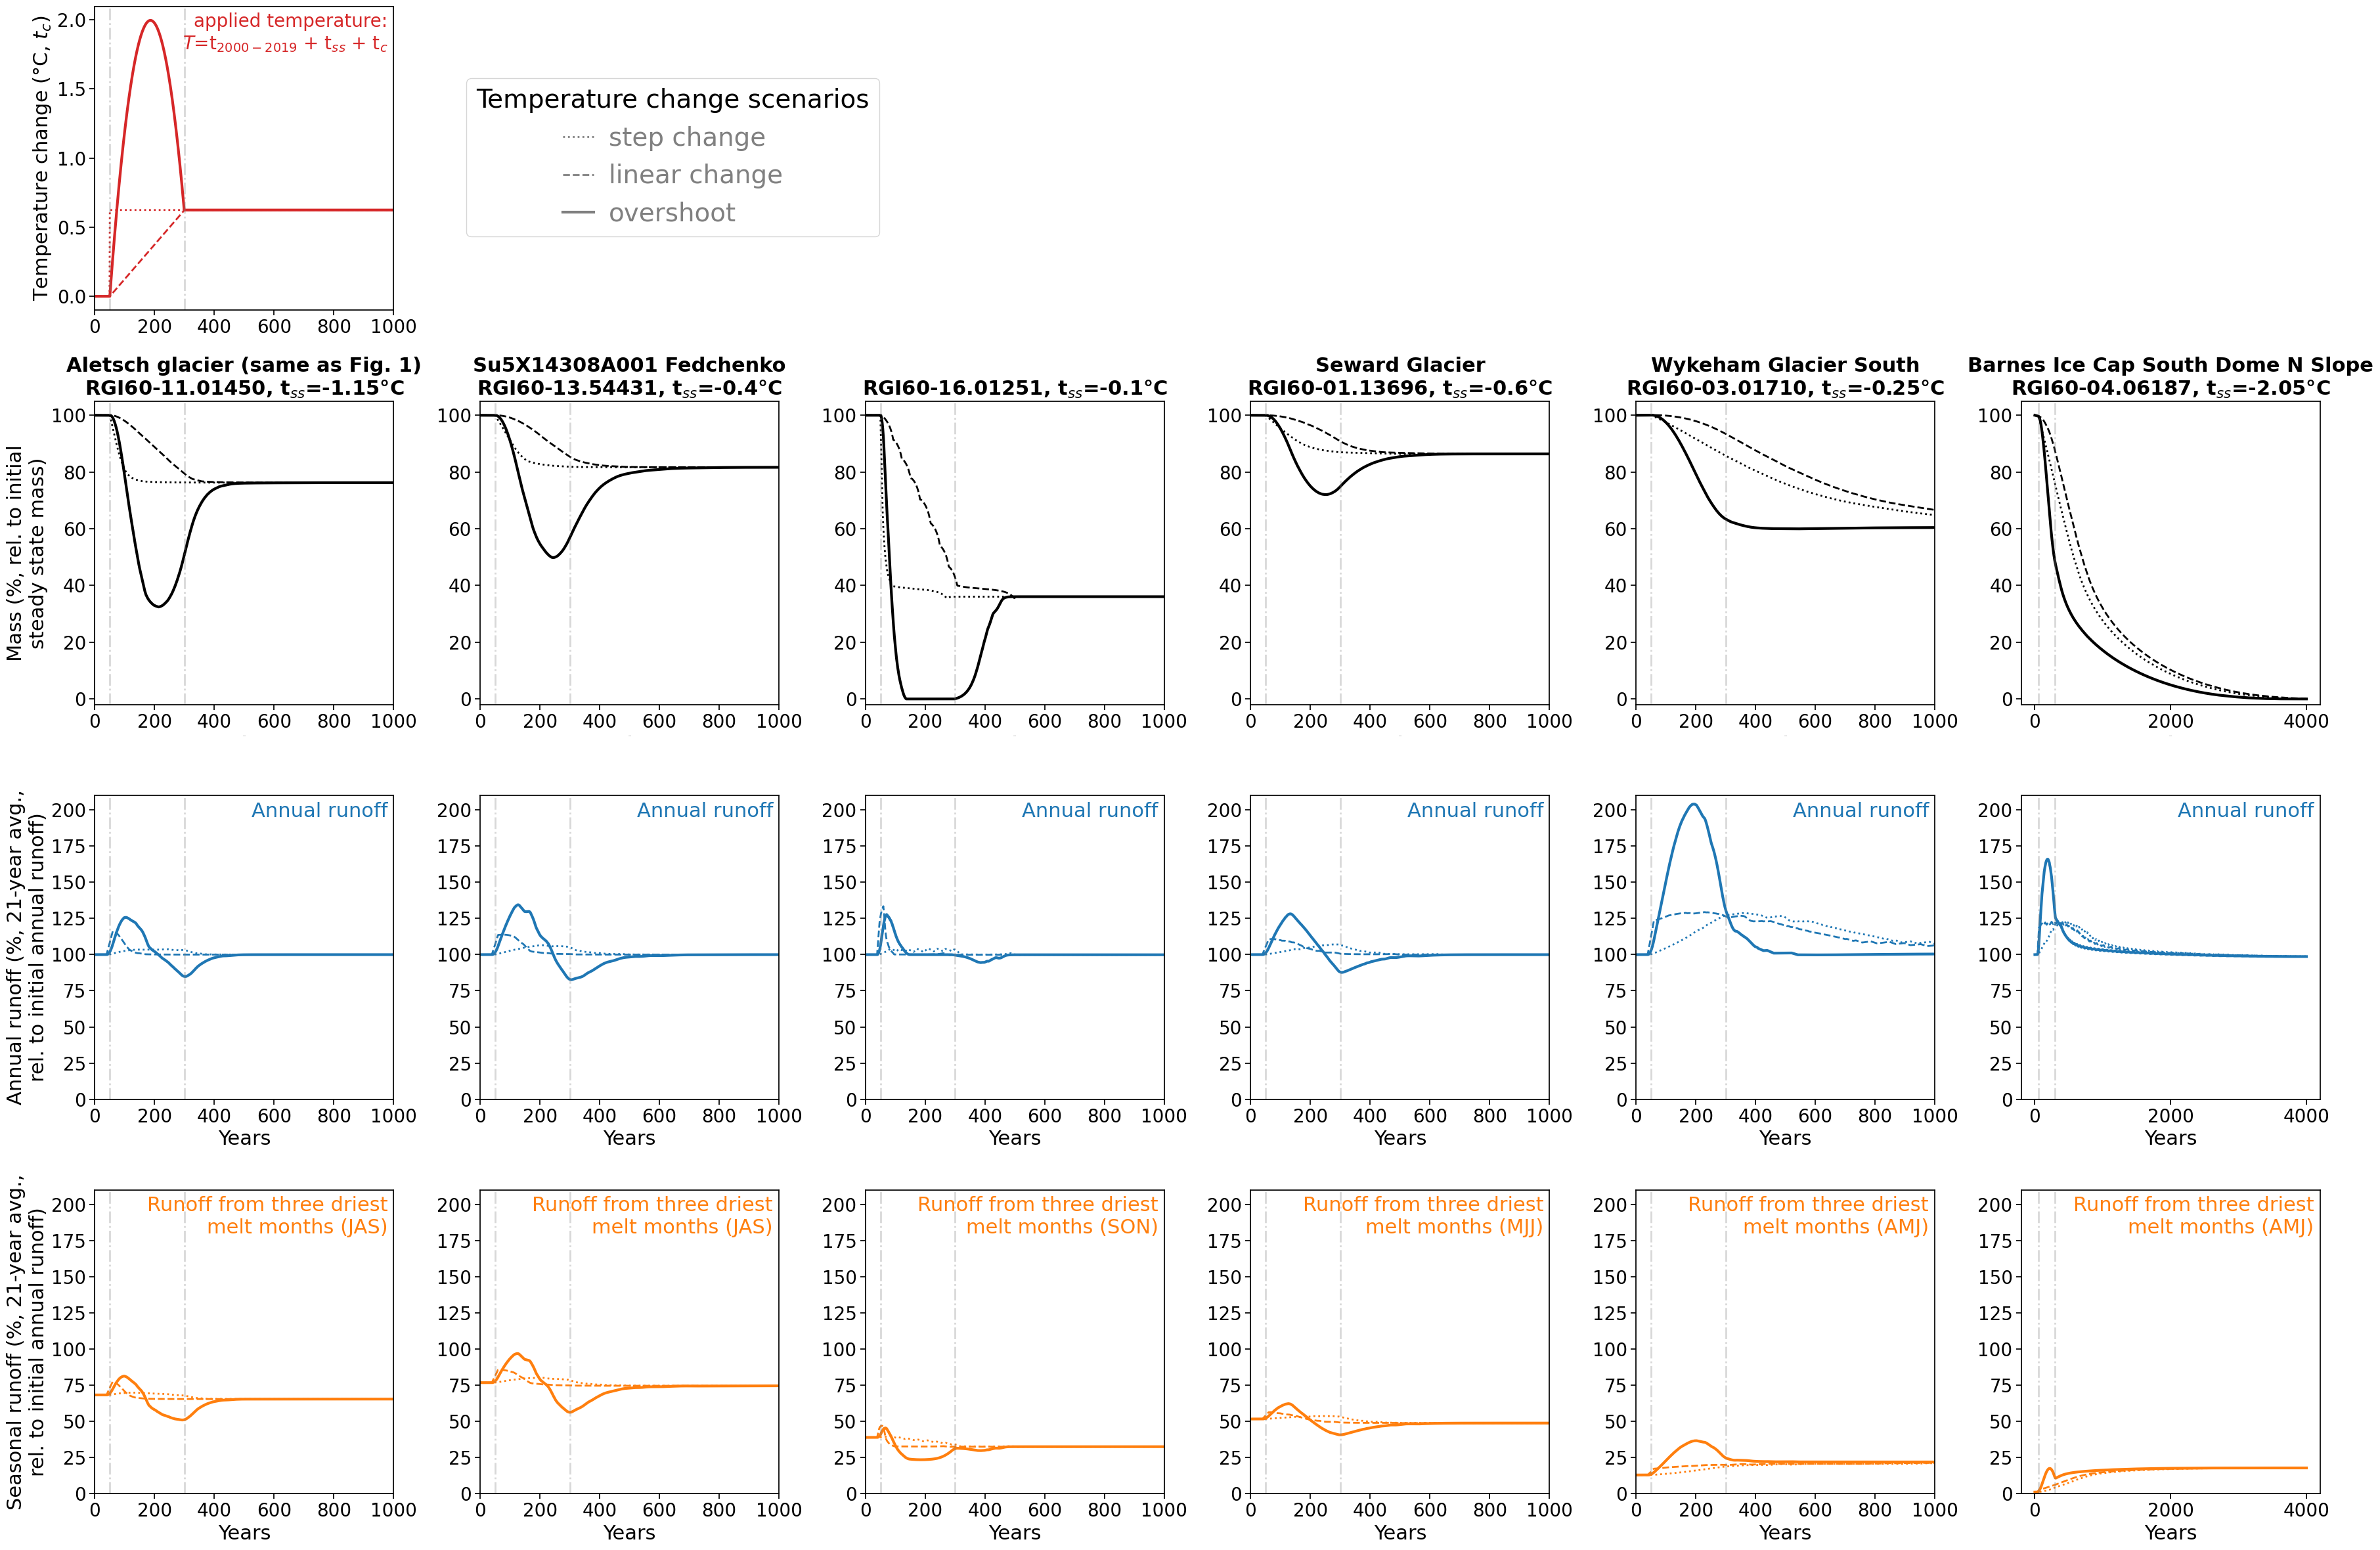

In [26]:
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(36, 24)) #sharex
plt.rc('font', size=20)

axs = axs.flatten()
#ds.length_m.plot(ax=axs[1]);
delta_t = dict_delta_t_rgi_eq[gdirs[-1].rgi_id]

(temp_bias_step-delta_t).plot(ax=axs[0], c='C3', ls=':', label='step change',lw=2);
(temp_bias_ts_lin-delta_t).plot(ax=axs[0], c='C3', ls='--', label='linear change',lw=2);
(temp_bias_ts-delta_t).plot(ax=axs[0], c='C3', label='overshoot', lw=3);
axs[0].text(0.98, 0.98, 'applied temperature:\n'+r'$T$=t$_{2000-2019}$ + t$_{ss}$ + t$_c$',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=20, color='C3')

axs[0].set_ylabel(r'Temperature change (°C, $t_c$)', fontsize=22); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')


    

#axs[0].annotate('temperature\ntarget',(480,temp_bias_step.iloc[-1]), xytext=(420,temp_bias_step.iloc[-1]*2.1),
#                color='C3',
#           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

fig.delaxes(axs[1])
fig.delaxes(axs[2])
fig.delaxes(axs[3])
fig.delaxes(axs[4])
fig.delaxes(axs[5])


###
n1 = 6
for j,gdir in enumerate(gdirs):
    _r = gdir.rgi_id
    ds = ds_d[_r]
    ds_lin = ds_lin_d[_r]
    ds_step = ds_step_d[_r]
    #axs[3+j].text(0.98, 0.98, 'Volume',
    #         ha='right', va='top', transform=axs[2+j].transAxes, 
    #        fontsize=22, color='black')
    (100*ds_step.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[6+j], c='black', ls=':',lw=2);
    (100*ds_lin.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[6+j], c='black', ls ='--',lw=2 );
    (100*ds.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[6+j], c='black', ls='-', lw=3);
    if j==0:
        axs[6+j].set_ylabel('Mass (%, rel. to initial\nsteady state mass)', fontsize=22)
    else:
        axs[6+j].set_ylabel('')
    
    #axs[1].set_title('Glacier volume', fontsize=22)
    eq0 = (ds.volume_m3/1e9).isel(time=0)
    eq1 = (ds.volume_m3/1e9).isel(time=-1)
    #axs[2+j].annotate('glacier in\nsteady-state',(20,eq0), xytext=(-20,eq0*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

    #axs[2+j].annotate('glacier in new\nsteady-state',(480,eq1), xytext=(420,eq1*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    #if j == 0:
    #    ylims = axs[4+j].get_ylim()
    #else:
    axs[6+j].set_ylim([-2,105])
        
    delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

    if '1450' in gdir.rgi_id:
        axs[6+j].set_title(f'Aletsch glacier (same as Fig. 1)\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=22)
    else:
        axs[6+j].set_title(f'{gdir.name}\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=22)
    axs[6+j].set_xlabel('Years', fontsize=0);         

###
n2 = 12
for j,gdir in enumerate(gdirs):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d[_r]
    df_runoff_lin = df_lin_runoff_d[_r]
    df_runoff_step = df_step_runoff_d[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff.sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_runoff_lin.sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_runoff_step.sum(axis=1).iloc[0]

    axs[n2+j].text(0.98, 0.98, 'Annual runoff',
             ha='right', va='top', transform=axs[n2+j].transAxes, 
            fontsize=22, color='C0')
    df_runoff_sum_rel_step.plot(ax=axs[n2+j], label = 'Annual runoff', c='C0', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[n2+j], label = 'Annual runoff', c='C0', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[n2+j], label = 'Annual runoff', c='C0', ls='-', lw=3);
    if j == 0:
        axs[n2+j].set_ylabel(f'Annual runoff (%, {roll}-year avg.,\nrel. to initial annual runoff)', fontsize=22)
    else:
        axs[n2+j].set_ylabel('')
    axs[n2+j].set_xlabel('Years', fontsize=22); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[n2+j].set_ylim([70,210])
    #axs[8+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='C0')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[4+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()

    #axs[4+j].annotate('trough water?',(tw_ind,tw*1.04), xytext=(tw_ind*1.2,tw*0.92),
    #             xycoords='data', textcoords='data', color='C0',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=18)
    
n3 = 18   
for j,gdir in enumerate(gdirs):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d_dry[_r]
    df_runoff_lin = df_lin_runoff_d_dry[_r]
    df_runoff_step = df_step_runoff_d_dry[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_lin_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_step_runoff_d[_r].sum(axis=1).iloc[0]
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    if m_last == 9:
        ms = 'JAS'
    elif m_last == 6:
        ms = 'AMJ'
    elif m_last == 11:
        ms = 'SON'
    elif m_last == 7:
        ms = 'MJJ'
    else:
        print ('sth. wrong')
    axs[n3+j].text(0.98, 0.98, f'Runoff from three driest\nmelt months ({ms})',
             ha='right', va='top', transform=axs[n3+j].transAxes, 
            fontsize=22, color='tab:orange')
    df_runoff_sum_rel_step.plot(ax=axs[n3+j], label = 'Seasonal runoff', c='tab:orange', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[n3+j], label = 'Seasonal runoff', c='tab:orange', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[n3+j], label = 'Seasonal runoff', c='tab:orange', ls='-', lw=3);
    if j == 0:
        axs[n3+j].set_ylabel(f'Seasonal runoff (%, {roll}-year avg.,\nrel. to initial annual runoff)', fontsize=22)
    else:
        axs[n3+j].set_ylabel('')
    axs[n3+j].set_xlabel('Years', fontsize=22); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[n3+j].set_ylim([70,210])
    #axs[12+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='tab:orange')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()
    
for j,ax in enumerate(axs):
    yt = ax.get_yticks()
    xt = ax.get_xticks()
    ax.set_xticks(xt.astype(int)[1::2],xt.astype(int)[1::2] , fontsize=20)
    if j<n1:
        ax.set_yticks(yt[1::2],yt.round(1)[1::2], fontsize=20)
    elif j<n2:
        ax.set_yticks(np.arange(0,120,20), np.arange(0,120,20), fontsize=20)
    else:
        ax.set_yticks(np.arange(0,220,25), np.arange(0,220,25), fontsize=20)
    
    if j not in [n1+n1-1,n1+n1+n1-1,n1+n1+n1+n1-1]:
        ax.set_xlim([0,1000])
        ax.set_xticks(np.arange(0,1001,200),np.arange(0,1001,200) , fontsize=20)

    ax.axvline(300,color='grey',ls='-.', lw=2, alpha = 0.3)
    ax.axvline(50,color='grey',ls='-.', lw=2, alpha = 0.3)
    
plt.tight_layout()

leg = axs[0].legend(fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6, title='Temperature change scenarios', title_fontsize=28, 
                    #title_fontproperties = {'textcolor':'grey', 'fontsize':28},
                    loc = 'lower left', bbox_to_anchor=(1.2,0.2), ncol=1)

for j in np.arange(0,3,1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')

plt.savefig('figures/suppl_fig_idealised_1000.png')

### Same plot just with selected glaciers ... (not used in manuscript)... Basically old!

In [ ]:
gdirs_sel = [gdirs[0], 
            gdirs[2],
             gdirs[3],
             gdirs[4]]

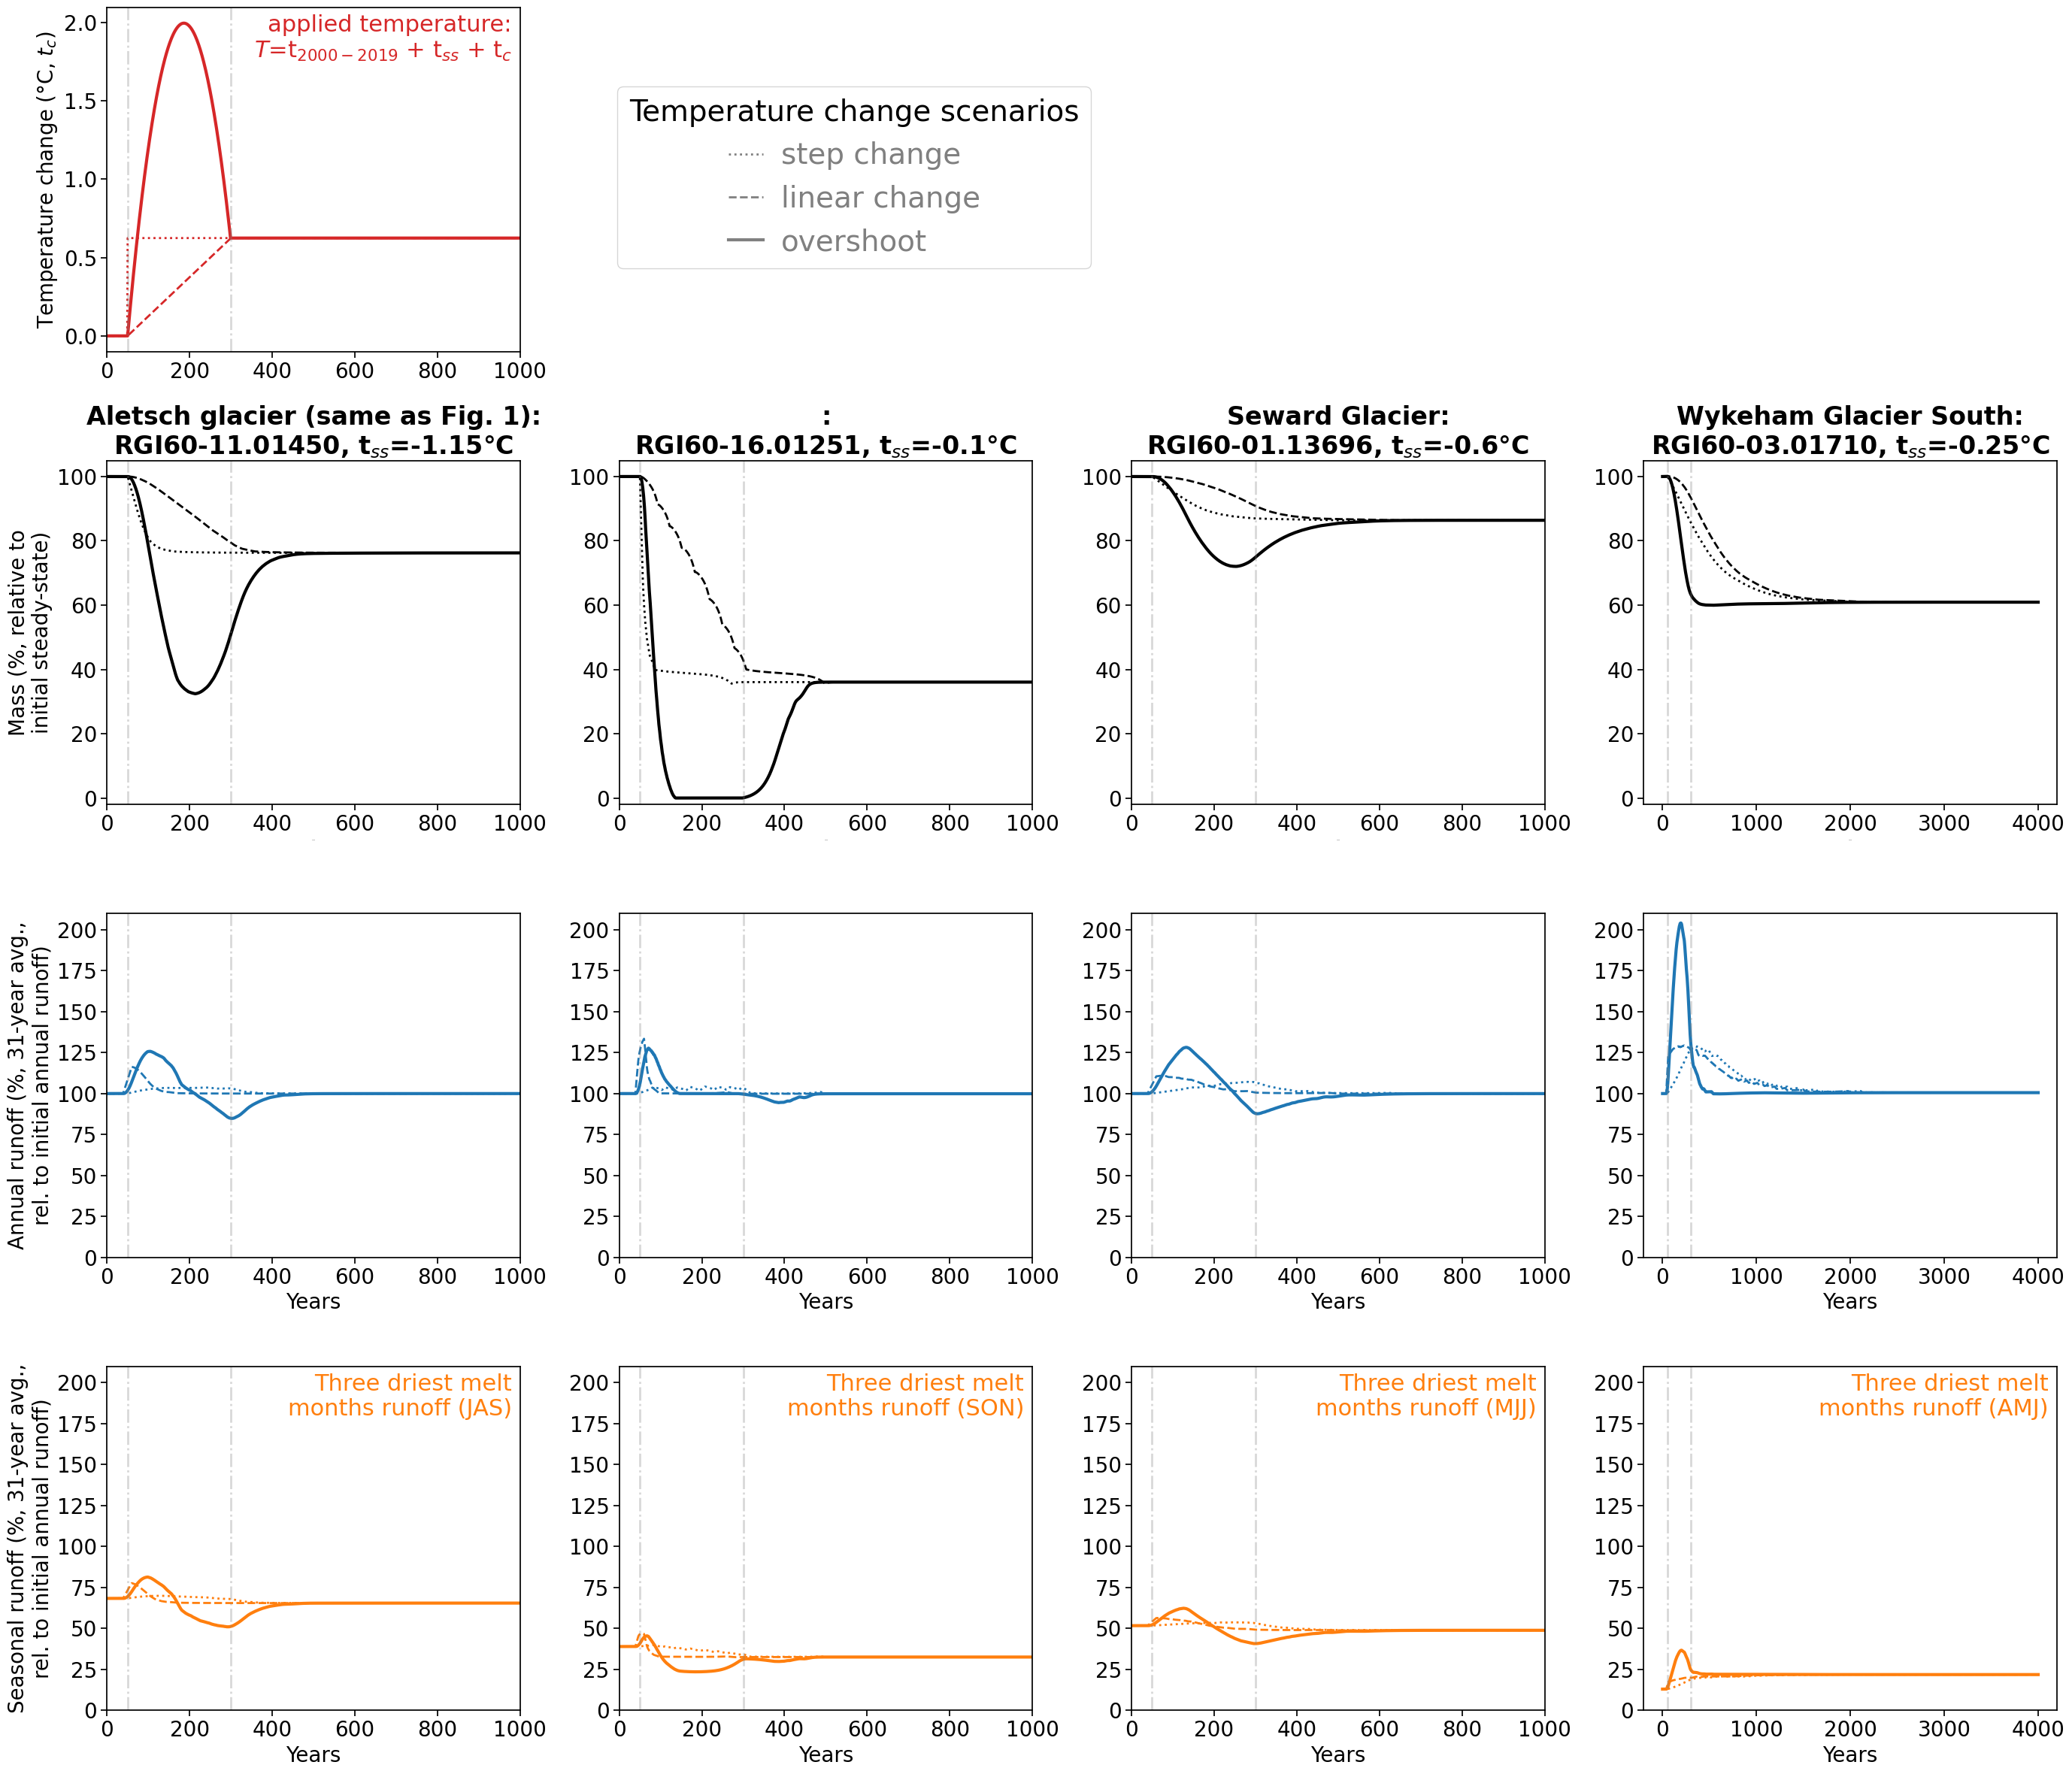

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(28, 24)) #sharex
plt.rc('font', size=20)

axs = axs.flatten()
#ds.length_m.plot(ax=axs[1]);
delta_t = dict_delta_t_rgi_eq[gdirs[-1].rgi_id]

(temp_bias_step-delta_t).plot(ax=axs[0], c='C3', ls=':', label='step change',lw=2);
(temp_bias_ts_lin-delta_t).plot(ax=axs[0], c='C3', ls='--', label='linear change',lw=2);
(temp_bias_ts-delta_t).plot(ax=axs[0], c='C3', label='overshoot', lw=3);
axs[0].text(0.98, 0.98, 'applied temperature:\n'+r'$T$=t$_{2000-2019}$ + t$_{ss}$ + t$_c$',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=22, color='C3')

axs[0].set_ylabel(r'Temperature change (°C, $t_c$)', fontsize=20); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')


    

#axs[0].annotate('temperature\ntarget',(480,temp_bias_step.iloc[-1]), xytext=(420,temp_bias_step.iloc[-1]*2.1),
#                color='C3',
#           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

fig.delaxes(axs[1])
fig.delaxes(axs[2])
fig.delaxes(axs[3])

###
for j,gdir in enumerate(gdirs_sel):
    _r = gdir.rgi_id
    ds = ds_d[_r]
    ds_lin = ds_lin_d[_r]
    ds_step = ds_step_d[_r]
    #axs[3+j].text(0.98, 0.98, 'Volume',
    #         ha='right', va='top', transform=axs[2+j].transAxes, 
    #        fontsize=22, color='black')
    (100*ds_step.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[4+j], c='black', ls=':',lw=2);
    (100*ds_lin.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[4+j], c='black', ls ='--',lw=2 );
    (100*ds.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[4+j], c='black', ls='-', lw=3);
    if j==0:
        axs[4+j].set_ylabel('Mass (%, relative to\ninitial steady-state)', fontsize=20)
    else:
        axs[4+j].set_ylabel('')
    
    #axs[1].set_title('Glacier volume', fontsize=22)
    eq0 = (ds.volume_m3/1e9).isel(time=0)
    eq1 = (ds.volume_m3/1e9).isel(time=-1)
    #axs[2+j].annotate('glacier in\nsteady-state',(20,eq0), xytext=(-20,eq0*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

    #axs[2+j].annotate('glacier in new\nsteady-state',(480,eq1), xytext=(420,eq1*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    #if j == 0:
    #    ylims = axs[4+j].get_ylim()
    #else:
    axs[4+j].set_ylim([-2,105])
        
    delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

    if '1450' in gdir.rgi_id:
        axs[4+j].set_title(f'Aletsch glacier (same as Fig. 1):\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=24)
    else:
        axs[4+j].set_title(f'{gdir.name}:\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=24)
    axs[4+j].set_xlabel('Years', fontsize=0);         

###
for j,gdir in enumerate(gdirs_sel):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d[_r]
    df_runoff_lin = df_lin_runoff_d[_r]
    df_runoff_step = df_step_runoff_d[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff.sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_runoff_lin.sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_runoff_step.sum(axis=1).iloc[0]

    #axs[6+j].text(0.98, 0.98, 'Annual runoff',
    #         ha='right', va='top', transform=axs[6+j].transAxes, 
    #        fontsize=22, color='C0')
    df_runoff_sum_rel_step.plot(ax=axs[8+j], label = 'Annual runoff', c='C0', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[8+j], label = 'Annual runoff', c='C0', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[8+j], label = 'Annual runoff', c='C0', ls='-', lw=3);
    if j == 0:
        axs[8+j].set_ylabel('Annual runoff (%, 31-year avg.,\nrel. to initial annual runoff)', fontsize=20)
    else:
        axs[8+j].set_ylabel('')
    axs[8+j].set_xlabel('Years', fontsize=20); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[8+j].set_ylim([70,210])
    #axs[8+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='C0')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[4+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()

    #axs[4+j].annotate('trough water?',(tw_ind,tw*1.04), xytext=(tw_ind*1.2,tw*0.92),
    #             xycoords='data', textcoords='data', color='C0',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=18)
    
    
for j,gdir in enumerate(gdirs_sel):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d_dry[_r]
    df_runoff_lin = df_lin_runoff_d_dry[_r]
    df_runoff_step = df_step_runoff_d_dry[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_lin_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_step_runoff_d[_r].sum(axis=1).iloc[0]
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    if m_last == 9:
        ms = 'JAS'
    elif m_last == 6:
        ms = 'AMJ'
    elif m_last == 11:
        ms = 'SON'
    elif m_last == 7:
        ms = 'MJJ'
    else:
        print ('sth. wrong')
    axs[12+j].text(0.98, 0.98, f'Three driest melt\nmonths runoff ({ms})',
             ha='right', va='top', transform=axs[12+j].transAxes, 
            fontsize=22, color='tab:orange')
    df_runoff_sum_rel_step.plot(ax=axs[12+j], label = 'Seasonal runoff', c='tab:orange', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[12+j], label = 'Seasonal runoff', c='tab:orange', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[12+j], label = 'Seasonal runoff', c='tab:orange', ls='-', lw=3);
    if j == 0:
        axs[12+j].set_ylabel('Seasonal runoff (%, 31-year avg.,\nrel. to initial annual runoff)', fontsize=20)
    else:
        axs[12+j].set_ylabel('')
    axs[12+j].set_xlabel('Years', fontsize=20); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[12+j].set_ylim([70,210])
    #axs[12+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='tab:orange')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()
    
for j,ax in enumerate(axs):
    yt = ax.get_yticks()
    xt = ax.get_xticks()
    ax.set_xticks(xt.astype(int)[1::2],xt.astype(int)[1::2] , fontsize=20)
    if j<4:
        ax.set_yticks(yt[1::2],yt.round(1)[1::2], fontsize=20)
    elif j<8:
        ax.set_yticks(np.arange(0,120,20), np.arange(0,120,20), fontsize=20)
    else:
        ax.set_yticks(np.arange(0,220,25), np.arange(0,220,25), fontsize=20)
    
    if j not in [7,11,15]:
        ax.set_xlim([0,1000])
        ax.set_xticks(np.arange(0,1001,200),np.arange(0,1001,200) , fontsize=20)

    ax.axvline(300,color='grey',ls='-.', lw=2, alpha = 0.3)
    ax.axvline(50,color='grey',ls='-.', lw=2, alpha = 0.3)
    
plt.tight_layout()

leg = axs[0].legend(fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6, title='Temperature change scenarios', title_fontsize=28, 
                    #title_fontproperties = {'textcolor':'grey', 'fontsize':28},
                    loc = 'lower left', bbox_to_anchor=(1.2,0.2), ncol=1)

for j in np.arange(0,3,1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')

plt.savefig('figures/suppl_fig_idealised_1000_sel.png')

**Only melt analysis**

In [10]:
runoff_vars

['melt_off_glacier',
 'melt_on_glacier',
 'liq_prcp_off_glacier',
 'liq_prcp_on_glacier']

In [13]:
roll = 1


df_runoff_melt_d = {}
df_lin_runoff_melt_d = {}
df_step_runoff_melt_d = {}

melt_vars = ['melt_off_glacier',
             'melt_on_glacier']

gdir = gdirs[0]
    
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_oversh_temp')) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_lin_temp')) as ds_lin:
    ds_lin = ds_lin.isel(time=slice(0, -1)).load()

with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_step_temp')) as ds_step:
    ds_step = ds_step.isel(time=slice(0, -1)).load()

runoff_vars_monthly = ['melt_off_glacier_monthly',
                       'melt_on_glacier_monthly',
                       'liq_prcp_off_glacier_monthly',
                       'liq_prcp_on_glacier_monthly']

labels_nice_dict = {'melt_off_glacier_monthly': 'melt off glacier',
                    'melt_on_glacier_monthly': 'melt on glacier',
                    'liq_prcp_off_glacier_monthly': 'liquid precipitation off glacier',
                    'liq_prcp_on_glacier_monthly': 'liquid precipitation on glacier'}
sel_vars_m = [v for v in ds.variables if 'month_2d' in ds[v].dims]
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]




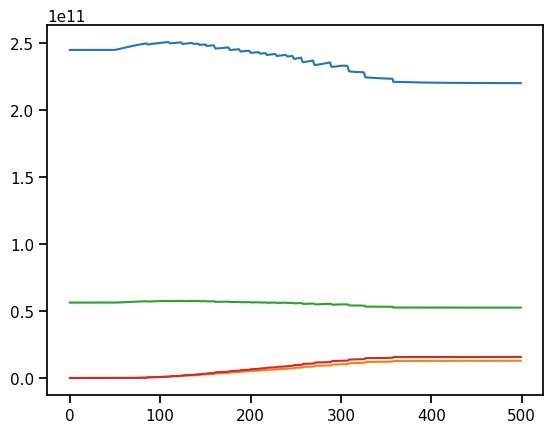

In [21]:
plt.plot(ds_lin['melt_on_glacier'].isel(time=slice(0,500)), label='melt_on_glacier')
plt.plot(ds_lin['melt_off_glacier'].isel(time=slice(0,500)), label='melt_off_glacier')
plt.plot(ds_lin['liq_prcp_on_glacier'].isel(time=slice(0,500)), label='liq_prcp_on_glacier')
plt.plot(ds_lin['liq_prcp_off_glacier'].isel(time=slice(0,500)), label='liq_prcp_off_glacier')

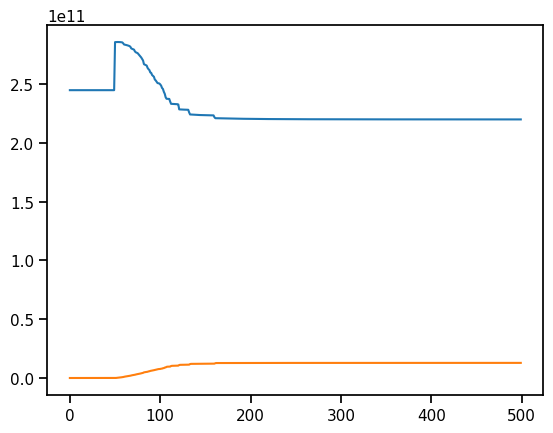

In [19]:
plt.plot(ds_step['melt_on_glacier'].isel(time=slice(0,500)))
plt.plot(ds_step['melt_off_glacier'].isel(time=slice(0,500)))

In [ ]:

    
for _d,_f in zip([ds,ds_lin,ds_step],
                 [df_runoff_d,df_step_runoff_d,df_lin_runoff_d]):


    df_annual = _d[sel_vars].to_dataframe()
    # Select only the runoff variables
    # Convert them to megatonnes (instead of kg)
    df_runoff = df_annual[runoff_vars] * 1e-9
    # We smooth the output, which is otherwize noisy because of area discretization
    df_runoff = df_runoff.rolling(roll, center=True, min_periods=1).mean()
    df_runoff = df_runoff.rename(columns=labels_nice_dict)

    _f[gdir.rgi_id] = df_runoff

for _d,_f in zip([ds,ds_lin,ds_step],
             [df_runoff_d_dry,df_step_runoff_d_dry,df_lin_runoff_d_dry]):   
    # todo change the numbers 
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    m_first = m_last-2
    print(gdir.rgi_id, m_first, m_last)
    df_summer = _d[sel_vars_m].sel(month_2d=slice(m_first,m_last)).sum(dim='month_2d').to_dataframe()
    # Convert them to megatonnes (instead of kg)
    df_runoff_sum = df_summer[runoff_vars_monthly] * 1e-9
    # We smooth the output, which is otherwize noisy because of area discretization
    df_runoff_sum = df_runoff_sum.rolling(roll, center=True, min_periods=1).mean()
    _f[gdir.rgi_id] = df_runoff_sum#.sum(axis=1)
#df_runoff_d[gdir.rgi_id] = df_runoff
#df_step_runoff_d[gdir.rgi_id] = df_step_runoff
#df_lin_runoff_d[gdir.rgi_id] = df_lin_runoff

**Old**

In [ ]:
#plt.legend()
m = 2
axs[m].text(0.98, 0.88, 'Melt-season runoff',
         ha='right', va='top', transform=axs[m].transAxes, 
        fontsize=22, color='C4')
df_runoff_sum_step.sum(axis=1).plot(ax=axs[m], c='C4', ls=':');
df_runoff_sum_lin.sum(axis=1).plot(ax=axs[m],  c='C4', ls='--');
df_runoff_sum.sum(axis=1).plot(ax=axs[m], c='C4', ls='-', lw=3);
axs[m].fill_between(df_runoff_sum.sum(axis=1).index,
                    df_runoff_sum.sum(axis=1).iloc[0], df_runoff_sum.sum(axis=1).values, alpha = 0.3, color='C4')
#leg = axs[3].legend(title='Melt-season glacier runoff', title_fontsize=22, frameon=False)#, fontsize=20)
#leg.get_title().set_color('C4')


#plt.ylabel('Melt-season runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
#plt.plot(df_runoff_sum.index, np.repeat(df_runoff_sum.sum(axis=1).iloc[0], len(df_runoff_sum)),
#         c='cyan', ls='-.',lw=0.4)
#ax.set_xticks([])
num_text_x = 0.01
num_text_y = 0.9
for j,ax in enumerate(axs):
    ax.set_yticks([]);
    ax.set_xticks([],[])
    ax.text(num_text_x, num_text_y,
            num_dict[j], fontsize=24, transform=ax.transAxes)
    ax.axvline(300, ls='-', lw=0.5, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.5, alpha =0.4, color='grey', zorder=0)
axs[2].set_xlabel('Time', fontsize=22); #axs[0].set_ylabel('Temperature bias (°C)');
plt.tight_layout();
#plt.savefig('figures/overshoot_conceptual_model_2.pdf')